In this directory I use astronomical images to train neural network. In this notebook I start with the simple case of stars versus galaxies. That should be relatively simple, at least with sufficient signal to noise. 

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#wcs is incompabible with newest numpy thus below not used 
#from astropy import wcs
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression


Now loading the data on the classification and other properties of the objects to be classified. 

In [2]:
df=pd.read_csv('Stripe82_1.csv',sep=',')
print(df.columns)

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'subclass', 'redshift', 'plate', 'mjd',
       'fiberid'],
      dtype='object')


Now looking on the classes, the targets and their counts. 

In [3]:
print(df['class'].value_counts())

GALAXY    3205
STAR      1735
QSO        355
Name: class, dtype: int64


Making a color (a difference of two magntudes) magnitude diagram. Thiskind of data (there are in total 5 magnitudes) could also be used for classification. 
For now it is ignore since the aim is to use images first. 

(26.0, 12.0)

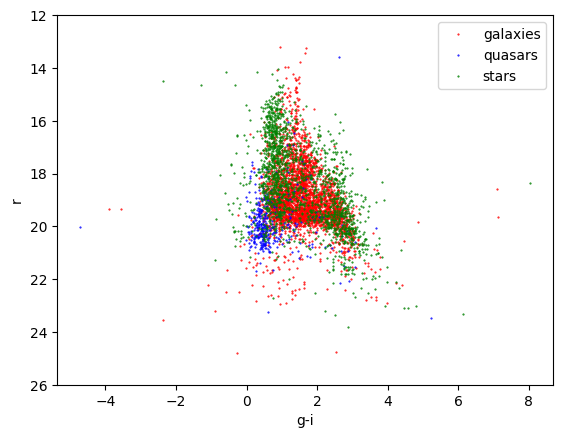

In [4]:
plt.plot(df['g'][df['class']=='GALAXY']-df['i'][df['class']=='GALAXY'],df['r'][df['class']=='GALAXY'],'o',ms=0.5,color='red',label='galaxies') 
plt.plot(df['g'][df['class']=='QSO']-df['i'][df['class']=='QSO'],df['r'][df['class']=='QSO'],'o',ms=0.5,color='blue',label='quasars')
plt.plot(df['g'][df['class']=='STAR']-df['i'][df['class']=='STAR'],df['r'][df['class']=='STAR'],'o',ms=0.5,color='green',label='stars')
plt.legend(loc="best")
plt.xlabel("g-i")
plt.ylabel("r")
plt.ylim(26,12)
#plt.yscale("log")


Now I load an image and to do a first test display of the numeric data.

In [5]:
path='/home/tobias/ml-testing/astr-images/'
hbin=fits.open(path+'f2001_rdeep.fits.gz')
im1=hbin[0].data
#hbin.close()
print(im1)

[[-0.1769429   0.8691173   0.8408659  ... -1.000337   -0.7853276
  -0.45219374]
 [ 0.75963277 -0.4932522   1.3954576  ... -0.41785482 -1.3604484
  -0.5760638 ]
 [ 0.74020797  0.50546163  0.67057353 ...  0.37528276 -0.6279215
  -0.12317654]
 ...
 [ 0.8284947   0.14578946 -0.6937766  ...  1.4887718   2.2809432
   2.2037222 ]
 [ 0.9416072   0.7137203   0.43595394 ...  1.1946634   2.0303423
   2.3305871 ]
 [ 0.57620764 -0.2957804   0.5933519  ...  0.98817205  1.3469133
   2.5567775 ]]


I now built a function which gets the area mcovers by an image. That is used later to find the right image for the targets.

In [6]:
def image_area(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    image=dat[0].data
    res=np.array([[ra_ref+(1-ra_center)*ra_scale,ra_ref+(image.shape[0]-ra_center)*ra_scale],[dec_ref+(1-dec_center)*dec_scale,dec_ref+(image.shape[1]-dec_center)*dec_scale]])
    return res

Similiarly the function image_par gets the coordinate parameter of an image for this data set.

In [7]:
#assumes that the image pixel coordiantes are perfectly aligned with the skyb coordiates ra and dec
#that is true for this data set but in general another two parameters are needed to specify the miss alignment
def image_par(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    par=np.array([ra_ref,ra_center,ra_scale,dec_ref,dec_center,dec_scale])
    return par

Below I test the image area function.

In [8]:
res=image_area(hbin)
print(res)

[[50.00036 49.49964]
 [-1.25036 -0.74964]]


Below I build a function which gets the image position of an object whose sky position is known. 
The information on the image can be either obtained from an image or from the opreviously collected image coordinate parameters.

In [9]:
#ra dec position coordinate of object, dat is image inpt, not zero if image==True,
# par is parameter inpu not yero if image==False
def image_xy(ra,dec,dat=0,par=0,image=True):
    #image is used input and the parameters are used
    if image==True:
        ra_ref=dat[0].header['CRVAL1']
        ra_center=dat[0].header['CRPIX1']
        ra_scale=dat[0].header['CD1_1']
        dec_ref=dat[0].header['CRVAL2']
        dec_center=dat[0].header['CRPIX2']
        dec_scale=dat[0].header['CD2_2'] 
    #paramter input    
    else:   
        ra_ref=par[0]
        ra_center=par[1]
        ra_scale=par[2]
        dec_ref=par[3]
        dec_center=par[4]
        dec_scale=par[5]
    #get the positions (pixels on image) 
    # the cosine part is only important if the image not close to the euqator 
    x=ra_center+(ra-ra_ref)/ra_scale*np.cos(dec/180*np.pi)
    y=dec_center+(dec-dec_ref)/dec_scale
    pixels=np.array([x,y])
    return pixels

Test use on image.

In [10]:
pixels=image_xy(49.8,-1,dat=hbin,image=True)
print(f"pixels are {pixels}")

pixels are [1822.52377493 2277.        ]


Now getting all images in a list. 

In [11]:
list_input_files=[f for f in os.listdir(path) 
    if f.endswith('_rdeep.fits.gz') and os.path.isfile(os.path.join(path, f))]
list_input_files.sort()
print(list_input_files)

['f2001_rdeep.fits.gz', 'f2002_rdeep.fits.gz', 'f2003_rdeep.fits.gz', 'f2004_rdeep.fits.gz', 'f2005_rdeep.fits.gz', 'f2011_rdeep.fits.gz', 'f2012_rdeep.fits.gz', 'f2013_rdeep.fits.gz', 'f2014_rdeep.fits.gz', 'f2015_rdeep.fits.gz', 'f2021_rdeep.fits.gz', 'f2022_rdeep.fits.gz', 'f2023_rdeep.fits.gz', 'f2024_rdeep.fits.gz', 'f2025_rdeep.fits.gz', 'f2031_rdeep.fits.gz', 'f2032_rdeep.fits.gz', 'f2033_rdeep.fits.gz', 'f2034_rdeep.fits.gz', 'f2035_rdeep.fits.gz', 'f2041_rdeep.fits.gz', 'f2042_rdeep.fits.gz', 'f2043_rdeep.fits.gz', 'f2044_rdeep.fits.gz', 'f2045_rdeep.fits.gz', 'f2051_rdeep.fits.gz', 'f2052_rdeep.fits.gz', 'f2053_rdeep.fits.gz', 'f2054_rdeep.fits.gz', 'f2055_rdeep.fits.gz', 'f2061_rdeep.fits.gz', 'f2062_rdeep.fits.gz', 'f2063_rdeep.fits.gz', 'f2064_rdeep.fits.gz', 'f2065_rdeep.fits.gz']


Now I get the centers and image parameters for all images.

In [12]:
centers=np.zeros((2,len(list_input_files)))
wcs_par=np.zeros((6,len(list_input_files)))
for i in range(len(list_input_files)):
    print(i)
    #get images
    hbin=fits.open(path+list_input_files[i],memmap=True)
    #get parameters wanted 
    res=image_area(hbin)
    par=image_par(hbin)
    hbin.close()
    centers[0,i]=(res[0,0]+res[0,1])/2  #center is avarage of extension in both dimensions
    centers[1,i]=(res[1,0]+res[1,1])/2
    #parameters to find objects on images
    wcs_par[:,i]=par
print(centers)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
[[ 4.97500000e+01  4.97500000e+01  4.97500000e+01  4.97500000e+01
   4.97500000e+01  5.02500000e+01  5.02500000e+01  5.02500000e+01
   5.02500000e+01  5.02500000e+01  5.07500000e+01  5.07500000e+01
   5.07500000e+01  5.07500000e+01  5.07500000e+01  5.12500000e+01
   5.12500000e+01  5.12500000e+01  5.12500000e+01  5.12500000e+01
   5.17500000e+01  5.17500000e+01  5.17500000e+01  5.17500000e+01
   5.17500000e+01  5.22500000e+01  5.22500000e+01  5.22500000e+01
   5.22500000e+01  5.22500000e+01  5.27500000e+01  5.27500000e+01
   5.27500000e+01  5.27500000e+01  5.27500000e+01]
 [-1.00000000e+00 -5.00000000e-01 -1.08246745e-15  5.00000000e-01
   1.00000000e+00 -1.00000000e+00 -5.00000000e-01 -1.08246745e-15
   5.00000000e-01  1.00000000e+00 -1.00000000e+00 -5.00000000e-01
  -1.08246745e-15  5.00000000e-01  1.00000000e+00 -1.00000000e+00
  -5.00000000e-01 -1.08246745e-15  5.00000000e-01  1.00000000e

Now I am getting closest image and the pixels positions on them for all objects of the data frame. Further I create a binary classifier based on whether a galaxy or not to start with a  simple binary classification case. I assume thereby that QSOs are like stars which should be at least approximate the case. 

In [13]:
df['galaxy'] = np.where(df['class']== 'GALAXY', True, False)
#Also I add dummy columns which are later filter with the image and the pixels positions on it for all onbjects
df['image']=-1
df['pixel_x']=-1.0
df['pixel_y']=-1.0
print(df.galaxy.value_counts())

True     3205
False    2090
Name: galaxy, dtype: int64


Printing the head to check whether adding the columns worked. 

In [14]:
print(df.head())

                 objid         ra       dec         u         g         r  \
0  1237657586029232289  52.309974 -0.114058  19.39700  18.27151  17.83080   
1  1237657586029297724  52.435195 -0.052648  17.03745  15.54729  14.91894   
2  1237660240851632288  52.459253  0.004838  19.59124  18.45930  17.97956   
3  1237660241388372059  52.165082  0.451840  20.17925  18.58868  17.87951   
4  1237660241388372089  52.225211  0.560895  19.95980  18.16988  17.40830   

          i         z   run  rerun  ...  class  subclass  redshift plate  \
0  17.67991  17.64519  2820    301  ...   STAR        F5  0.000097  2049   
1  14.66624  14.54055  2820    301  ...   STAR        F9  0.000067  2049   
2  17.62496  17.48819  3438    301  ...   STAR        F5  0.000323  2049   
3  17.59933  17.43295  3438    301  ...   STAR        K1  0.000151  2049   
4  17.09896  16.91901  3438    301  ...   STAR        K1  0.000098  2049   

     mjd  fiberid  galaxy  image  pixel_x  pixel_y  
0  53350      438   False  

Below I go over all objects, find the closest image and get then the pixel position of the object.. 

In [15]:
for i in range(df.shape[0]):
    #distances to all images ceneters
    r=np.sqrt((df['ra'][i]-centers[0])**2+(df['dec'][i]-centers[1])**2)
    #id of the image
    df['image'].iloc[i]=np.argmin(r)
    #get pixel coordinates of image 
    coor=image_xy(df['ra'][i],df['dec'][i],par=wcs_par[:,df['image'].iloc[i]],image=False)
    df['pixel_x'].iloc[i]=coor[0]
    df['pixel_y'].iloc[i]=coor[1]
    

/tmp/ipykernel_2776/3953301984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'].iloc[i]=np.argmin(r)
/tmp/ipykernel_2776/3953301984.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixel_x'].iloc[i]=coor[0]
/tmp/ipykernel_2776/3953301984.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixel_y'].iloc[i]=coor[1]


Checking whether the columns are now filled with right coordinates. 

In [16]:
print(df.head())

                 objid         ra       dec         u         g         r  \
0  1237657586029232289  52.309974 -0.114058  19.39700  18.27151  17.83080   
1  1237657586029297724  52.435195 -0.052648  17.03745  15.54729  14.91894   
2  1237660240851632288  52.459253  0.004838  19.59124  18.45930  17.97956   
3  1237660241388372059  52.165082  0.451840  20.17925  18.58868  17.87951   
4  1237660241388372089  52.225211  0.560895  19.95980  18.16988  17.40830   

          i         z   run  rerun  ...  class  subclass  redshift plate  \
0  17.67991  17.64519  2820    301  ...   STAR        F5  0.000097  2049   
1  14.66624  14.54055  2820    301  ...   STAR        F9  0.000067  2049   
2  17.62496  17.48819  3438    301  ...   STAR        F5  0.000323  2049   
3  17.59933  17.43295  3438    301  ...   STAR        K1  0.000151  2049   
4  17.09896  16.91901  3438    301  ...   STAR        K1  0.000098  2049   

     mjd  fiberid  galaxy  image      pixel_x      pixel_y  
0  53350      438  

Analyse the new columns content. 

In [17]:
#sorted by value to see which iamges are used
print(df.image.value_counts().sort_index(0))
print(df.pixel_x.describe())
print(df.pixel_y.describe())

5     227
6     181
7     231
8     244
9     190
10    154
11    192
12    245
13    257
14    227
15    149
16    167
17    203
18    153
19    168
20    173
21    238
22    199
23    199
24    195
25    247
26    277
27    279
28    261
29    239
Name: image, dtype: int64
count    5295.000000
mean     2297.375179
std      1304.735601
min         4.991131
25%      1179.141102
50%      2323.782704
75%      3418.760954
max      4549.603869
Name: pixel_x, dtype: float64
count    5295.000000
mean     2253.338893
std      1304.361251
min       -70.538413
25%      1145.468620
50%      2213.411517
75%      3379.435823
max      4637.182527
Name: pixel_y, dtype: float64


/tmp/ipykernel_2776/1114175374.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  print(df.image.value_counts().sort_index(0))


I now sort the row of the data frame by image, that minizie how often the images need to be loaded. 

In [18]:
df=df.sort_values(by='image')
#reset index since the previous row is not wanted 
df=df.reset_index()
print(df.head)

<bound method NDFrame.head of       index                objid         ra       dec         u         g  \
0      2168  1237660239776908025  50.312948 -0.767717  21.92582  21.18044   
1      1286  1237663237128520044  50.432160 -1.103514  21.96684  20.35859   
2      1287  1237663237128520058  50.439437 -1.164617  22.09616  20.93119   
3       592  1237663237128388950  50.162303 -1.235258  22.20764  19.81604   
4       593  1237663237128388967  50.174576 -1.245299  22.56767  20.52426   
...     ...                  ...        ...       ...       ...       ...   
5290   1850  1237660241925243553  52.205533  0.894619  20.34502  19.15812   
5291   1851  1237660241925243604  52.226615  0.989524  21.01873  19.88625   
5292   2121  1237666301630087433  52.100141  0.771115  19.86979  18.74825   
5293   2126  1237666302167024104  52.167572  1.184058  20.93733  20.05359   
5294   5294  1237666302166958580  52.037329  1.219908  22.68021  21.35267   

             r         i         z   run  ...

Now the arrays with the images are collected. For now I collected 11 times 11 pixels. The n umber is odd because it should usually centered on the brightest image. 

In [19]:
delta=5
#collected array
cut_outs=np.zeros((2*delta+1,2*delta+1,df.shape[0]))
#parameter to indicate whether an image exist. 
df['off_image']=False
for i in range(df.shape[0]):
    #image loaded if first image
    if i==0:
        #load file
        hbin=fits.open(path+list_input_files[df.image.iloc[i]])
        #get image, need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
        image=hbin[0].data.T
    else:
        #or if new image
        if df.image.iloc[i]!=df.image.iloc[i-1]:
            hbin=fits.open(path+list_input_files[df.image.iloc[i]])
            #need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
            image=hbin[0].data.T  
    #gfigure out if within image borders  then cut out image is collected       
    if round(df.pixel_x.iloc[i])>delta and round(df.pixel_x.iloc[i])<image.shape[0]-delta and  round(df.pixel_y.iloc[i])>delta and round(df.pixel_y.iloc[i])<image.shape[1]-delta:
        cut_outs[:,:,i]=image[round(df.pixel_x.iloc[i])-delta:round(df.pixel_x.iloc[i])+delta+1,round(df.pixel_y.iloc[i])-delta:round(df.pixel_y.iloc[i])+delta+1]
    else:
        #if not marker column set to true
        print(f"row {i} is off the image")
        df['off_image'].iloc[i]=True

row 109 is off the image
row 110 is off the image
row 111 is off the image


/tmp/ipykernel_2776/4177535269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['off_image'].iloc[i]=True


row 939 is off the image
row 982 is off the image
row 993 is off the image
row 994 is off the image
row 1011 is off the image
row 1312 is off the image
row 2063 is off the image
row 2098 is off the image
row 2241 is off the image
row 2655 is off the image
row 2820 is off the image
row 2850 is off the image
row 2870 is off the image
row 2875 is off the image
row 2964 is off the image
row 2993 is off the image
row 3047 is off the image
row 3101 is off the image
row 3724 is off the image
row 3837 is off the image
row 3855 is off the image
row 3912 is off the image
row 3918 is off the image
row 4041 is off the image
row 4209 is off the image
row 4715 is off the image
row 4835 is off the image
row 5077 is off the image
row 5168 is off the image
row 5200 is off the image
row 5211 is off the image
row 5257 is off the image
row 5258 is off the image


Now I check how rows are off the image.

In [20]:
print(df.off_image.value_counts())

False    5259
True       36
Name: off_image, dtype: int64


Not many, thus they can be ignore. Now  display one object of each kind. 

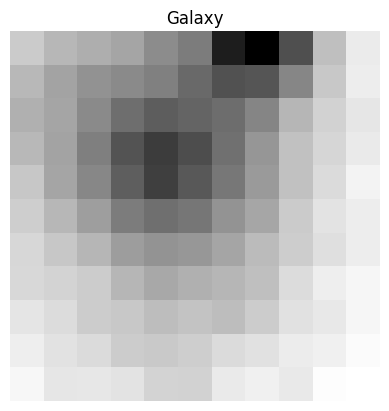

In [21]:
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs[:,:,0].T,cmap=cm.gray, interpolation='nearest')

In [22]:
#finding star and galaxies for display
fs=df['class'][df['class']=='STAR']
print(fs)
fq=df['class'][df['class']=='QSO']
print(fq)

11      STAR
15      STAR
16      STAR
17      STAR
20      STAR
        ... 
5266    STAR
5267    STAR
5269    STAR
5278    STAR
5292    STAR
Name: class, Length: 1735, dtype: object
25      QSO
41      QSO
45      QSO
63      QSO
64      QSO
       ... 
5191    QSO
5242    QSO
5246    QSO
5253    QSO
5288    QSO
Name: class, Length: 355, dtype: object


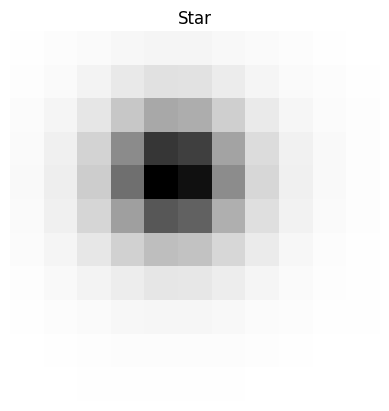

In [23]:
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs[:,:,fs.index[0]].T,cmap=cm.gray, interpolation='nearest')

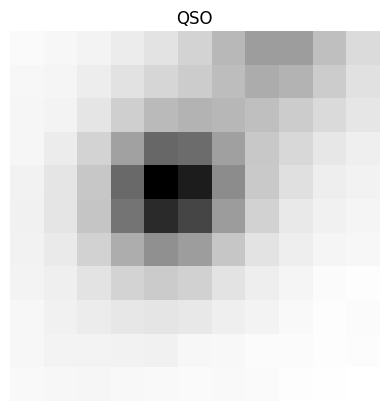

In [24]:
plt.axis('off')
plt.title("QSO")
plt.imshow(1-cut_outs[:,:,fq.index[0]].T,cmap=cm.gray, interpolation='nearest')

As it should be the galaxy is less concentrated than the star and the QSO. It is also visisble that the object are not fully isolated as often the case for images. 

I now drop the objects for which no image could have been found. I also add a forth dimension to the iamge array as needed by pytorch. I could add other colors, but for now I just use one color. The color I use combines the three color with the highest signal to noise to a single. That is useful in astronomy because astronomical images are noisy. 

Because of the noise to I not rescale the cut out images, since rescaling makes that noise is level is very different between different images, while it should be rather similar in this data set.    

In [25]:
#new data frame omitting the object where no image could be found 
df2=df[df.off_image==False]
#new image array, to which also a 4 dimension of zero size is added 
cut_outs2=np.zeros((2*delta+1,2*delta+1,1,df2.shape[0]))
counter=0
for i in range(df.shape[0]):
    if df.off_image.iloc[i]==False:
        #adding the cut outs not of image
        cut_outs2[:,:,0,counter]=cut_outs[:,:,i]
        counter+=1
#Now I add the iamge value to the data frame, that can be used for all connected percitron networks 
x=0
for i in range(cut_outs2.shape[0]):
    for j in range(cut_outs2.shape[1]):
        df2[x]=cut_outs2[i,j,0,:]
        x+=1

/tmp/ipykernel_2776/1758981368.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_2776/1758981368.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_2776/1758981368.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Printing the head as test as often. 

In [26]:
print(df2.head())

   index                objid         ra       dec         u         g  \
0   2168  1237660239776908025  50.312948 -0.767717  21.92582  21.18044   
1   1286  1237663237128520044  50.432160 -1.103514  21.96684  20.35859   
2   1287  1237663237128520058  50.439437 -1.164617  22.09616  20.93119   
3    592  1237663237128388950  50.162303 -1.235258  22.20764  19.81604   
4    593  1237663237128388967  50.174576 -1.245299  22.56767  20.52426   

          r         i         z   run  ...        111        112        113  \
0  19.97416  19.64367  19.27409  3438  ...   6.554533   7.593651   7.016401   
1  19.48765  19.06683  18.82782  4136  ...   5.149033   5.307359   6.223897   
2  19.48183  18.93008  18.48824  4136  ...  11.629539  13.926988  10.528815   
3  18.69533  18.23049  17.89898  4136  ...   6.260189   7.919204  12.064778   
4  19.25002  18.78460  18.39242  4136  ...   2.556708   3.418560   5.017884   

         114        115        116        117        118        119        120  

Now the data is mostly prepared besides some libraries specifices. 



First I do basic setup tasks relevant for for all torch networks. For now that these are two, firstly a fully connected multilayer network as perceptron. Secondly, a network which uses twodiemnsionalk convolutional layer whoch should be optimized for images. 

First adding the cpu. 

In [27]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [28]:
#need to be transposed to get into torch format of batch, channels, x, y
#splitting, feature_mlp, targets, feature_images, df properties
feature_train,feature_test,target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df2.loc[:,0:120],df2.loc[:,"galaxy"],cut_outs2.T,df2,train_size=0.70, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)

shape of image train data
(3681, 1, 11, 11)


Now I change the target data type to numpy array where that is not yet the case. 

In [29]:
 
feature_train, target_train = np.array(feature_train), np.array(target_train)
feature_test, target_test = np.array(feature_test), np.array(target_test)
print(type(target_train),type(image_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Now I create a class which creates the classification data sets as needed for torch. 

In [30]:
class ClassificationDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

Now I create the data sets as needed for both neural network types. 

In [31]:
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
#print type as test 
print(type(torch.from_numpy(image_test).float()))
print(type(test_im_dataset))


<class 'torch.Tensor'>
<class '__main__.ClassificationDataset'>


Now create the class of the perceptron layer. 

In [32]:
#now 3 layers 
#two options only 
class BinaryClassification3(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification3, self).__init__()
        self.fc1 = nn.Linear(num_features, 60)
        self.fc2 = nn.Linear(60, 20)  
        self.fc3 = nn.Linear(20, 8)        
        self.fc4 = nn.Linear(8, 1)   
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return (x)

Now I define the parameters needed. 

In [33]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = 121
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Finally I define the model plus the final parameters. 

In [35]:
model =BinaryClassification3(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#in loss_stats the statistic is collected 
loss_stats = {
    'train': [], 'test': []
}


BinaryClassification3(
  (fc1): Linear(in_features=121, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)


Now I run the fit. 

In [36]:

print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        test_epoch_loss = 0
        
        model.eval()
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            y_test_pred = model(X_test_batch)
                        
            test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
            test_epoch_loss += test_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.44679 | Test Loss: 0.35491
Epoch 002: | Train Loss: 0.47000 | Test Loss: 0.26419
Epoch 003: | Train Loss: 0.43835 | Test Loss: 0.33320
Epoch 004: | Train Loss: 0.43468 | Test Loss: 0.33353
Epoch 005: | Train Loss: 0.40517 | Test Loss: 0.34189
Epoch 006: | Train Loss: 0.40891 | Test Loss: 0.58342
Epoch 007: | Train Loss: 0.37597 | Test Loss: 0.21247
Epoch 008: | Train Loss: 0.37767 | Test Loss: 0.34311
Epoch 009: | Train Loss: 0.38517 | Test Loss: 0.34827
Epoch 010: | Train Loss: 0.36743 | Test Loss: 0.33201
Epoch 011: | Train Loss: 0.33467 | Test Loss: 0.16485
Epoch 012: | Train Loss: 0.36029 | Test Loss: 0.39088
Epoch 013: | Train Loss: 0.29325 | Test Loss: 0.27533
Epoch 014: | Train Loss: 0.31559 | Test Loss: 0.41769
Epoch 015: | Train Loss: 0.33150 | Test Loss: 0.20935
Epoch 016: | Train Loss: 0.32301 | Test Loss: 0.14586
Epoch 017: | Train Loss: 0.27303 | Test Loss: 0.13961
Epoch 018: | Train Loss: 0.31963 | Test Loss: 0.14096
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.11295 | Test Loss: 0.25387
Epoch 154: | Train Loss: 0.09610 | Test Loss: 0.24984
Epoch 155: | Train Loss: 0.09333 | Test Loss: 0.25044
Epoch 156: | Train Loss: 0.09850 | Test Loss: 0.20385
Epoch 157: | Train Loss: 0.10084 | Test Loss: 0.19086
Epoch 158: | Train Loss: 0.08695 | Test Loss: 0.18541
Epoch 159: | Train Loss: 0.08786 | Test Loss: 0.18212
Epoch 160: | Train Loss: 0.09209 | Test Loss: 0.18185
Epoch 161: | Train Loss: 0.09173 | Test Loss: 0.19693
Epoch 162: | Train Loss: 0.13573 | Test Loss: 0.18303
Epoch 163: | Train Loss: 0.10631 | Test Loss: 0.17545
Epoch 164: | Train Loss: 0.10647 | Test Loss: 0.23998
Epoch 165: | Train Loss: 0.09044 | Test Loss: 0.17569
Epoch 166: | Train Loss: 0.09891 | Test Loss: 0.18923
Epoch 167: | Train Loss: 0.09194 | Test Loss: 0.17929
Epoch 168: | Train Loss: 0.09527 | Test Loss: 0.18037
Epoch 169: | Train Loss: 0.09152 | Test Loss: 0.17947
Epoch 170: | Train Loss: 0.09674 | Test Loss: 0.18367
Epoch 171: | Train Loss: 0.0

Now I define a function which predicts the values (probablities) for all samples. 

In [45]:
def pred_torch(model,data):
    y_pred_list_c = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list_c.append(y_test_pred.cpu().numpy())
    y_pred_list_c = [a.squeeze().tolist() for a in y_pred_list_c]
    return y_pred_list_c  

That is then applied on all data. 

In [38]:
m_test=pred_torch(model,test_loader)
m_train=pred_torch(model,train_loader_pred)

I now plot the loss against the epoch. 

Text(0, 0.5, 'BCE loss')

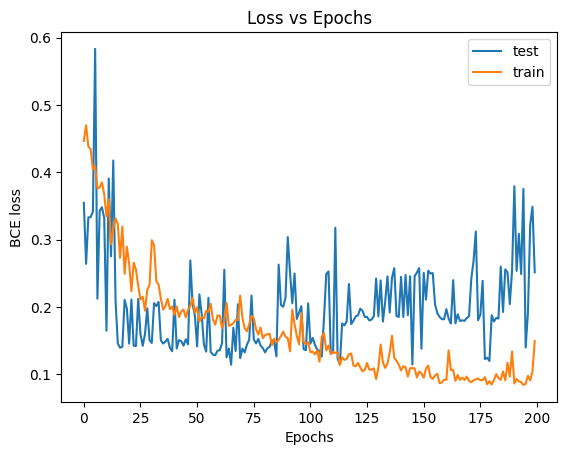

In [39]:

plt.plot(loss_stats['test'],label='test')
plt.plot(loss_stats['train'],label='train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

There is likely overfitting, at least the loss of test improves less at the end.

Now I am building a first convolutional network. First loading the data again.  

In [34]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)

Below is a not changed neural network copied from somewhere. 

In [35]:
# Implementation of CNN/ConvNet Model  image 28 *28 size not changed  
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        # Conv -> (?, 28, 28, 32)
        # Pool -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        # Conv      ->(?, 14, 14, 64)
        # Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 62, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        # Conv ->(?, 7, 7, 128)
        # Pool ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Below I check how input and output depends on each other to make no mistakes in  it.

In [36]:
input0 = torch.randn(1, 1, 11, 11)
b=torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
output0=b(input0)
print(f"first conv layer input: {input0.shape} output: {output0.shape}")

m = nn.MaxPool2d((2, 2), stride=(2, 2))
#standard drops but can be changed, can also use pooling and co get better number 
output = m(output0)
print(f"max pool input:{output0.shape} input:{output.shape}")
#input format (Batch, Number Channels, height, width)
b2=torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
input2 = torch.randn(1, 16, 4, 4)
output2=b2(input2)
print(f"second conv layer input: {input2.shape} output: {output2.shape}")
output3 = m(output2)
print(f"second max pool layer input: {output2.shape} output: {output3.shape}")

first conv layer input: torch.Size([1, 1, 11, 11]) output: torch.Size([1, 16, 9, 9])
max pool input:torch.Size([1, 16, 9, 9]) input:torch.Size([1, 16, 4, 4])
second conv layer input: torch.Size([1, 16, 4, 4]) output: torch.Size([1, 32, 2, 2])
second max pool layer input: torch.Size([1, 32, 2, 2]) output: torch.Size([1, 32, 1, 1])


Now I build the network. 

In [37]:
class CNNBinary3(torch.nn.Module):
    #no padding because image does not really end when the data ends. 
    def __init__(self):
        super(CNNBinary3, self).__init__()
        # L1 ImgIn shape=(?, 11, 11, 1)
        # Conv -> (?, 9, 9, 12)
        # Pool -> (?, 4, 4, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 4, 4, 32)
        # Conv      ->(?, 2, 2, 32)
        # Pool      ->(?, 1, 1, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 FC 1x1x32 inputs -> 16 outputs
        self.fc1 = torch.nn.Linear(1 * 1 * 32, 64, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 Final FC 64 inputs -> 1 output
        self.fc2 = torch.nn.Linear(64, 1, bias=True) #
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = torch.sigmoid(self.fc2(out))
        return out

Define the model. 

In [44]:
keep_prob=1
model2 =CNNBinary3()
model2.to(device)
print(model2)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/tmp/ipykernel_18239/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


In [41]:
#define the function to fit it
#parameters: model used, train_data, test_data, epchs, batch_size, learning_rate, file to collect sats, 
#optional regularization 
def torch_fit(model,train_loader,test_loader,epochs,batch_size,learning_rate,loss_stats,l2reg=0):
    learning_rate = learning_rate
    criterion = torch.nn.BCELoss()    # Softmax is internally computed.
    #if no regularization
    if l2reg==0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    #l2 regularization is added in optimizer as weight_decay=1e-5 or nsimilar 
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate,weight_decay=l2reg)        
    print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
        
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer.step()
        
            train_epoch_loss += train_loss.item()
        
        
        # VALIDATION    
        with torch.no_grad():
        
            test_epoch_loss = 0
        
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
                y_test_pred = model(X_test_batch)
                        
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
                test_epoch_loss += test_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')    

Now define the array for data collection and then fit the data. 

In [46]:
loss_stats_test = {
    'train': [], 'test': []
}
torch_fit(model2,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 8.68696 | Test Loss: 0.72433
Epoch 002: | Train Loss: 0.73891 | Test Loss: 0.54297
Epoch 003: | Train Loss: 0.79793 | Test Loss: 0.55971
Epoch 004: | Train Loss: 1.34847 | Test Loss: 0.69846
Epoch 005: | Train Loss: 0.55812 | Test Loss: 0.62137
Epoch 006: | Train Loss: 0.39375 | Test Loss: 0.45812
Epoch 007: | Train Loss: 0.32053 | Test Loss: 0.33146
Epoch 008: | Train Loss: 0.38559 | Test Loss: 0.39676
Epoch 009: | Train Loss: 0.28657 | Test Loss: 0.44737
Epoch 010: | Train Loss: 0.29845 | Test Loss: 0.31829
Epoch 011: | Train Loss: 0.34817 | Test Loss: 0.32054
Epoch 012: | Train Loss: 0.26035 | Test Loss: 0.26114
Epoch 013: | Train Loss: 0.24912 | Test Loss: 0.27995
Epoch 014: | Train Loss: 0.25536 | Test Loss: 0.26955
Epoch 015: | Train Loss: 0.24724 | Test Loss: 0.26479
Epoch 016: | Train Loss: 0.24457 | Test Loss: 0.26590
Epoch 017: | Train Loss: 0.24877 | Test Loss: 0.25863
Epoch 018: | Train Loss: 0.22939 | Test Loss: 0.18744
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.22640 | Test Loss: 0.21675
Epoch 154: | Train Loss: 0.18880 | Test Loss: 0.20346
Epoch 155: | Train Loss: 0.17273 | Test Loss: 0.28477
Epoch 156: | Train Loss: 0.13996 | Test Loss: 0.35097
Epoch 157: | Train Loss: 0.15935 | Test Loss: 0.22052
Epoch 158: | Train Loss: 0.15231 | Test Loss: 0.34736
Epoch 159: | Train Loss: 0.12891 | Test Loss: 0.23580
Epoch 160: | Train Loss: 0.13649 | Test Loss: 0.22643
Epoch 161: | Train Loss: 0.13524 | Test Loss: 0.22309
Epoch 162: | Train Loss: 0.13407 | Test Loss: 0.22008
Epoch 163: | Train Loss: 0.14049 | Test Loss: 0.22001
Epoch 164: | Train Loss: 0.13730 | Test Loss: 0.28194
Epoch 165: | Train Loss: 0.16013 | Test Loss: 0.23940
Epoch 166: | Train Loss: 0.14725 | Test Loss: 0.20791
Epoch 167: | Train Loss: 0.12811 | Test Loss: 0.21811
Epoch 168: | Train Loss: 0.13368 | Test Loss: 0.36330
Epoch 169: | Train Loss: 0.11785 | Test Loss: 0.23488
Epoch 170: | Train Loss: 0.12395 | Test Loss: 0.23710
Epoch 171: | Train Loss: 0.1

Below I plot both neural network results. 

(0.0, 3.0)

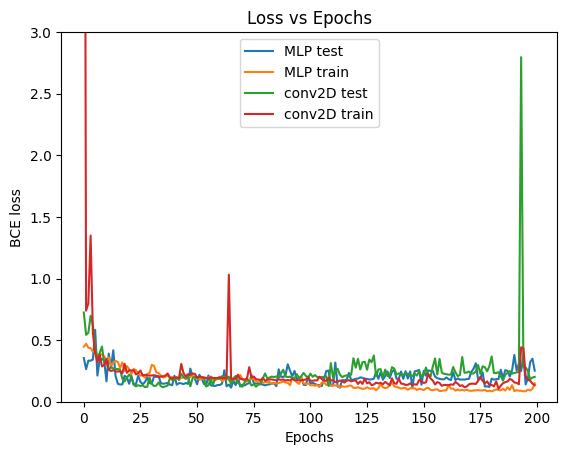

In [47]:
plt.plot(loss_stats['test'],label='MLP test')
plt.plot(loss_stats['train'],label='MLP train')
plt.plot(loss_stats_test['test'],label='conv2D test')
plt.plot(loss_stats_test['train'],label='conv2D train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.ylim(0,3)

Convolutional looks better, less overfitting, but it also not look perfect and the final loss is not really good. Could be not enough epochs for train. There are wiggles in test seem like that there is overfitting also there. REuslts change every fot slightly. 

Now I do some other algorithms with standard settings. First xgboost. 

In [95]:
xc1=XGBClassifier(max_depth=6).fit(feature_train,target_train)

Now predicting the results and getting the confusing matrixes. 

In [97]:
train_pred=xc1.predict(feature_train)
test_pred=xc1.predict(feature_test)
train_pred_prob=xc1.predict_proba(feature_train)
test_pred_prob=xc1.predict_proba(feature_test)
conf_train = confusion_matrix(target_train, train_pred)
conf_test = confusion_matrix(target_test, test_pred)
print("confusion matrix xgboost train")
print(conf_train)
print("confusion matrix xgboost test")
print(conf_test)

confusion matrix xgboost train
[[1468    0]
 [   0 2213]]
confusion matrix xgboost test
[[576  33]
 [ 38 931]]


Does not look so bad. 

Now logistic regression 

In [50]:
#2000 in train 91 56,  test 65 45  not converged warning
#now converged same numbers
lc1=LogisticRegression(max_iter=3000,penalty='none').fit(feature_train,target_train)

In [51]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, l_train_pred)
l_conf_test = confusion_matrix(target_test, l_test_pred)
print("confusion matrix logistic regression train")
print(l_conf_train)
print("confusion matrix logistic regression test")
print(l_conf_test)

confusion matrix logistic regression train
[[1377   91]
 [  56 2157]]
confusion matrix logistic regression test
[[544  65]
 [ 45 924]]


Also not so bad. However, both not perfect, thus possible that neural network is better. 

Now prediction for neural network. 

In [52]:
c_test=pred_torch(model2,test_im_loader)
c_train=pred_torch(model2,train_im_loader_pred)

Define function to get confusion matrix. 

In [53]:
def conf_for_torch(predict,target):
    #round prediction
    round_pred=np.round(np.array(predict))
    conf_matrix = confusion_matrix(target, round_pred)
    return conf_matrix

In [54]:
conf_test_m=conf_for_torch(m_test,target_test)
conf_train_m=conf_for_torch(m_train,target_train)
print("3 layer perceptron")
print("train")
print(conf_train_m)
print("test")
print(conf_test_m)

3 layer perceptron
train
[[1404   64]
 [  24 2189]]
test
[[578  31]
 [ 25 944]]


Percitron seems better than xgboost. 

Now convoltional network. 

In [55]:
conf_test_c=conf_for_torch(c_test,target_test)
conf_train_c=conf_for_torch(c_train,target_train)
print("2 conv2D layers conv2D one other")
print("train")
print(conf_train_c)
print("test")
print(conf_test_c)

2 conv2D layers conv2D one other
train
[[1418   50]
 [  17 2196]]
test
[[578  31]
 [ 24 945]]


Both look similar good. Now calculating f1-scores for all. 

In [56]:
print("F1-scores")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,train_pred),5)}")
print(f"xgboost test {np.round(f1_score(target_test,test_pred),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")

F1-scores
Logistic train 0.96705
Logistic test 0.94382
xgboost train 1.0
xgboost test 0.96269
perceptron train 0.9803
perceptron test 0.97119
conv2d train 0.98497
conv2d test 0.97172


Train not perfect for the neural networks. Perceptron is slightly betterab than conv2d and xgbooost but differences are small.


Now conv 2d with regularization. 

In [57]:
keep_prob=1
model3 =CNNBinary3()
model3.to(device)
print(model3)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/tmp/ipykernel_18239/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


In [58]:
loss_stats_test3 = {
    'train': [], 'test': []
}
torch_fit(model3,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test3,l2reg=0.0001)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.96241 | Test Loss: 0.92964
Epoch 002: | Train Loss: 0.75138 | Test Loss: 0.28023
Epoch 003: | Train Loss: 0.50646 | Test Loss: 0.31631
Epoch 004: | Train Loss: 0.36853 | Test Loss: 0.25407
Epoch 005: | Train Loss: 0.41477 | Test Loss: 0.19301
Epoch 006: | Train Loss: 0.35143 | Test Loss: 0.24134
Epoch 007: | Train Loss: 0.37198 | Test Loss: 0.18823
Epoch 008: | Train Loss: 0.27619 | Test Loss: 0.25515
Epoch 009: | Train Loss: 0.41105 | Test Loss: 0.26220
Epoch 010: | Train Loss: 0.24196 | Test Loss: 0.21376
Epoch 011: | Train Loss: 0.23376 | Test Loss: 0.15995
Epoch 012: | Train Loss: 0.22877 | Test Loss: 0.19962
Epoch 013: | Train Loss: 0.23808 | Test Loss: 0.20495
Epoch 014: | Train Loss: 0.22916 | Test Loss: 0.19748
Epoch 015: | Train Loss: 0.25532 | Test Loss: 0.19340
Epoch 016: | Train Loss: 0.22642 | Test Loss: 0.19121
Epoch 017: | Train Loss: 0.23270 | Test Loss: 0.19136
Epoch 018: | Train Loss: 0.22298 | Test Loss: 0.13653
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.18214 | Test Loss: 0.23378
Epoch 154: | Train Loss: 0.19163 | Test Loss: 0.25276
Epoch 155: | Train Loss: 0.18286 | Test Loss: 0.30403
Epoch 156: | Train Loss: 0.18762 | Test Loss: 0.27582
Epoch 157: | Train Loss: 0.17716 | Test Loss: 0.24687
Epoch 158: | Train Loss: 0.19346 | Test Loss: 0.23552
Epoch 159: | Train Loss: 0.18151 | Test Loss: 0.25429
Epoch 160: | Train Loss: 0.18925 | Test Loss: 0.27586
Epoch 161: | Train Loss: 0.19952 | Test Loss: 0.26268
Epoch 162: | Train Loss: 0.19337 | Test Loss: 0.30871
Epoch 163: | Train Loss: 0.18663 | Test Loss: 0.27590
Epoch 164: | Train Loss: 0.17959 | Test Loss: 0.33359
Epoch 165: | Train Loss: 0.18433 | Test Loss: 0.40433
Epoch 166: | Train Loss: 0.19829 | Test Loss: 0.42580
Epoch 167: | Train Loss: 0.19260 | Test Loss: 0.25689
Epoch 168: | Train Loss: 0.18411 | Test Loss: 0.34177
Epoch 169: | Train Loss: 0.18403 | Test Loss: 0.33276
Epoch 170: | Train Loss: 0.17913 | Test Loss: 0.36047
Epoch 171: | Train Loss: 0.1

(0.0, 0.7)

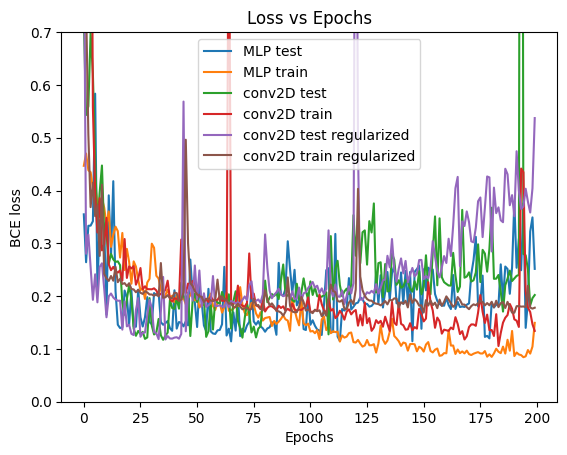

In [61]:
plt.plot(loss_stats['test'],label='MLP test')
plt.plot(loss_stats['train'],label='MLP train')
plt.plot(loss_stats_test['test'],label='conv2D test')
plt.plot(loss_stats_test['train'],label='conv2D train')
plt.plot(loss_stats_test3['test'],label='conv2D test regularized')
plt.plot(loss_stats_test3['train'],label='conv2D train regularized')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.ylim(0,0.7)
#1e-4 is not stable 
#0.1 looks clearly different 

In [62]:
c2_test=pred_torch(model3,test_im_loader)
c2_train=pred_torch(model3,train_im_loader_pred)
conf_test_c2=conf_for_torch(c2_test,target_test)
conf_train_c2=conf_for_torch(c2_train,target_train)
print("2 conv2D layers conv2D one other l2 regularized")
print("train")
print(conf_train_c2)
print("test")
print(conf_test_c2)

2 conv2D layers conv2D one other l2 regularized
train
[[1439   29]
 [  20 2193]]
test
[[578  31]
 [ 36 933]]


In [63]:
#0.1 train .96728 , test  0.96814 some variation with ransom ness
# 1 has train 0.9599 , test 0.9579
#0.3 train 0.96572, test 0.96758
#0.03 train  0.97216  test  0.9702
#0.01 train 0.97635  test 0.97491
#0.003 train  0.9764 test  0.97584
#0.001 train 0.97744 test 0.97744
#0.0001 train 0.98336 test 0.96651
print("F1-scores")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,train_pred),5)}")
print(f"xgboost test {np.round(f1_score(target_test,test_pred),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")
print(f"conv2d  regularized train {np.round(f1_score(target_train,np.round(c2_train)),5)}")
print(f"conv2d regularized test {np.round(f1_score(target_test,np.round(c2_test)),5)}")

F1-scores
Logistic train 0.96705
Logistic test 0.94382
xgboost train 1.0
xgboost test 0.96269
perceptron train 0.9803
perceptron test 0.97119
conv2d train 0.98497
conv2d test 0.97172
conv2d  regularized train 0.98895
conv2d regularized test 0.96534


Now also looking on log losses.

In [66]:
#0.001 train 0.12594 test xx
#0.0001 train 0.18472 test 0.22196
print("Log lossses")
print(f"Logistic train {np.round(log_loss(target_train,l_train_pred_prob),5)}")
print(f"Logistic test {np.round(log_loss(target_test,l_test_pred_prob),5)}")
print(f"xgboost train {np.round(log_loss(target_train,train_pred_prob),5)}")
print(f"xgboost test {np.round(log_loss(target_test,test_pred_prob),5)}")
print(f"perceptron  train {np.round(log_loss(target_train,(m_train)),5)}")
print(f"perceptron test {np.round(log_loss(target_test,(m_test)),5)}")
print(f"conv2d  train {np.round(log_loss(target_train,(c_train)),5)}")
print(f"conv2d test {np.round(log_loss(target_test,(c_test)),5)}")
print(f"conv2d  regularized train {np.round(log_loss(target_train,(c2_train)),5)}")
print(f"conv2d regularized test {np.round(log_loss(target_test,(c2_test)),5)}")

Log lossses
Logistic train 0.1629
Logistic test 0.31918
xgboost train 0.00243
xgboost test 0.16782
perceptron  train 0.10522
perceptron test 0.16862
conv2d  train 0.08935
conv2d test 0.16058
conv2d  regularized train 0.09093
conv2d regularized test 0.34823


For l2 of 0.1, looks now slightly better, similar in test and train from the f1 score. Still can be chance. And not better than perceptron. Regularization of 1 is too much, is less good f1 score then. ). For 0.3 is better in test but still worse than without regularization. Exploring now several options, there seems to be a best option  at some regularziation even although randomness also influences the results. 

Now I define a function to execute several l2 regularization of the same model after each other

In [67]:
#loop on regularization 
#model used, train set, test set, train set for predict, train_target, test_target
#epochs, batch?size, alpha of fit, list of regularization, optional number of features needed for perceptron 
def run_loop_torch(model,train,test,train_for_pred,train_target,test_target,epochs,batch,alpha,regs,num_features=0):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"running reg of {regs[i]}")
        keep_prob=1
        if num_features==0:
            model3 =model()
        else:
            #num_features partlz needed
            model3 =model(num_features)            
        model3.to(device)
        loss_stats_test3 = {
        'train': [], 'test': []
        }
        torch_fit(model3,train,test,epochs,batch,alpha,loss_stats_test3,l2reg=regs[i])
        test_pred=pred_torch(model3,test)
        train_pred=pred_torch(model3,train_for_pred)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(train_target,np.round(train_pred))
        stats[2,i]=f1_score(test_target,np.round(test_pred))
        stats[3,i]=log_loss(train_target,(train_pred))
        stats[4,i]=log_loss(test_target,(test_pred))   
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")
    return stats

 I run it for several regularization. I choose 200 epochs that convergence is possible when no overfitting occurs. With overfitting is will still change but since the aim here is to find the regularization which has not that problem, it is not a problem. 

In [76]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
conv2d_stats=run_loop_torch(CNNBinary3,train_im_loader,test_im_loader,train_im_loader_pred,target_train,target_test,200,64,0.001,regs)
np.savetxt("conv2d_reg1_200.txt",conv2d_stats)
#loading past run with more iterations
con2d_stats=np.loadtxt("conv2d_reg1_200.txt")

running reg of 0.0001
Begin training.


/tmp/ipykernel_18239/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.53673 | Test Loss: 0.36703
Epoch 002: | Train Loss: 0.54194 | Test Loss: 0.82949
Epoch 003: | Train Loss: 0.44282 | Test Loss: 0.19471
Epoch 004: | Train Loss: 0.42626 | Test Loss: 0.76378
Epoch 005: | Train Loss: 0.28977 | Test Loss: 0.25759
Epoch 006: | Train Loss: 0.35153 | Test Loss: 0.13040
Epoch 007: | Train Loss: 0.29651 | Test Loss: 0.17678
Epoch 008: | Train Loss: 0.27854 | Test Loss: 0.24535
Epoch 009: | Train Loss: 0.24052 | Test Loss: 0.18813
Epoch 010: | Train Loss: 0.20917 | Test Loss: 0.25058
Epoch 011: | Train Loss: 0.23992 | Test Loss: 0.18865
Epoch 012: | Train Loss: 0.26875 | Test Loss: 0.18578
Epoch 013: | Train Loss: 0.31460 | Test Loss: 0.23534
Epoch 014: | Train Loss: 0.22819 | Test Loss: 0.14184
Epoch 015: | Train Loss: 0.22355 | Test Loss: 0.13117
Epoch 016: | Train Loss: 0.21974 | Test Loss: 0.12274
Epoch 017: | Train Loss: 0.21709 | Test Loss: 0.12150
Epoch 018: | Train Loss: 0.21495 | Test Loss: 0.12689
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.15722 | Test Loss: 0.30010
Epoch 154: | Train Loss: 0.18757 | Test Loss: 0.29855
Epoch 155: | Train Loss: 0.18387 | Test Loss: 0.39889
Epoch 156: | Train Loss: 0.16080 | Test Loss: 0.37680
Epoch 157: | Train Loss: 0.14613 | Test Loss: 0.52202
Epoch 158: | Train Loss: 0.14701 | Test Loss: 0.38806
Epoch 159: | Train Loss: 0.15712 | Test Loss: 0.22742
Epoch 160: | Train Loss: 0.17056 | Test Loss: 0.32983
Epoch 161: | Train Loss: 0.15730 | Test Loss: 0.39760
Epoch 162: | Train Loss: 0.15301 | Test Loss: 0.41260
Epoch 163: | Train Loss: 0.15329 | Test Loss: 0.30496
Epoch 164: | Train Loss: 0.16287 | Test Loss: 0.30631
Epoch 165: | Train Loss: 0.15526 | Test Loss: 0.40888
Epoch 166: | Train Loss: 0.15234 | Test Loss: 0.27441
Epoch 167: | Train Loss: 0.15951 | Test Loss: 0.31962
Epoch 168: | Train Loss: 0.15303 | Test Loss: 0.37366
Epoch 169: | Train Loss: 0.15308 | Test Loss: 0.43035
Epoch 170: | Train Loss: 0.69890 | Test Loss: 0.50612
Epoch 171: | Train Loss: 0.5

/tmp/ipykernel_18239/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.65343 | Test Loss: 0.74078
Epoch 002: | Train Loss: 0.59274 | Test Loss: 0.34795
Epoch 003: | Train Loss: 0.54356 | Test Loss: 0.62265
Epoch 004: | Train Loss: 0.59927 | Test Loss: 0.24563
Epoch 005: | Train Loss: 0.36822 | Test Loss: 0.20329
Epoch 006: | Train Loss: 0.36154 | Test Loss: 0.25761
Epoch 007: | Train Loss: 0.29839 | Test Loss: 0.20258
Epoch 008: | Train Loss: 0.30133 | Test Loss: 0.19031
Epoch 009: | Train Loss: 0.33168 | Test Loss: 0.26530
Epoch 010: | Train Loss: 0.32794 | Test Loss: 0.25078
Epoch 011: | Train Loss: 0.30167 | Test Loss: 0.25087
Epoch 012: | Train Loss: 0.27243 | Test Loss: 0.19393
Epoch 013: | Train Loss: 0.25482 | Test Loss: 0.19401
Epoch 014: | Train Loss: 0.27855 | Test Loss: 0.32778
Epoch 015: | Train Loss: 0.28180 | Test Loss: 0.25248
Epoch 016: | Train Loss: 0.28533 | Test Loss: 0.19691
Epoch 017: | Train Loss: 0.27848 | Test Loss: 0.19321
Epoch 018: | Train Loss: 0.24937 | Test Loss: 0.20397
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.15604 | Test Loss: 0.22511
Epoch 154: | Train Loss: 0.16747 | Test Loss: 0.27212
Epoch 155: | Train Loss: 0.15987 | Test Loss: 0.35512
Epoch 156: | Train Loss: 0.19753 | Test Loss: 0.30140
Epoch 157: | Train Loss: 0.16629 | Test Loss: 0.29799
Epoch 158: | Train Loss: 0.15476 | Test Loss: 0.27533
Epoch 159: | Train Loss: 0.15301 | Test Loss: 0.36078
Epoch 160: | Train Loss: 0.15091 | Test Loss: 0.27816
Epoch 161: | Train Loss: 0.18437 | Test Loss: 0.30071
Epoch 162: | Train Loss: 0.18970 | Test Loss: 0.32113
Epoch 163: | Train Loss: 0.14864 | Test Loss: 0.30417
Epoch 164: | Train Loss: 0.14109 | Test Loss: 0.29870
Epoch 165: | Train Loss: 0.16135 | Test Loss: 0.28872
Epoch 166: | Train Loss: 0.15319 | Test Loss: 0.37407
Epoch 167: | Train Loss: 0.15195 | Test Loss: 0.29390
Epoch 168: | Train Loss: 0.14161 | Test Loss: 0.32214
Epoch 169: | Train Loss: 0.17627 | Test Loss: 0.32915
Epoch 170: | Train Loss: 0.19366 | Test Loss: 0.26881
Epoch 171: | Train Loss: 0.2

/tmp/ipykernel_18239/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.33620 | Test Loss: 0.65512
Epoch 002: | Train Loss: 0.85291 | Test Loss: 0.43669
Epoch 003: | Train Loss: 0.57866 | Test Loss: 0.41546
Epoch 004: | Train Loss: 0.44695 | Test Loss: 0.40136
Epoch 005: | Train Loss: 0.50146 | Test Loss: 0.49417
Epoch 006: | Train Loss: 0.45276 | Test Loss: 0.45510
Epoch 007: | Train Loss: 0.40550 | Test Loss: 0.33004
Epoch 008: | Train Loss: 0.40472 | Test Loss: 0.39014
Epoch 009: | Train Loss: 0.38157 | Test Loss: 0.32777
Epoch 010: | Train Loss: 0.37314 | Test Loss: 0.26720
Epoch 011: | Train Loss: 0.37819 | Test Loss: 0.34273
Epoch 012: | Train Loss: 0.45974 | Test Loss: 0.25934
Epoch 013: | Train Loss: 0.33234 | Test Loss: 0.27533
Epoch 014: | Train Loss: 0.31101 | Test Loss: 0.26310
Epoch 015: | Train Loss: 0.30625 | Test Loss: 0.26341
Epoch 016: | Train Loss: 0.29895 | Test Loss: 0.19080
Epoch 017: | Train Loss: 0.36493 | Test Loss: 0.26624
Epoch 018: | Train Loss: 0.28337 | Test Loss: 0.25825
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.23600 | Test Loss: 0.19200
Epoch 154: | Train Loss: 0.22134 | Test Loss: 0.19772
Epoch 155: | Train Loss: 0.20112 | Test Loss: 0.17570
Epoch 156: | Train Loss: 0.18302 | Test Loss: 0.18510
Epoch 157: | Train Loss: 0.18157 | Test Loss: 0.18019
Epoch 158: | Train Loss: 0.17733 | Test Loss: 0.19050
Epoch 159: | Train Loss: 0.17188 | Test Loss: 0.18927
Epoch 160: | Train Loss: 0.17701 | Test Loss: 0.19071
Epoch 161: | Train Loss: 0.17589 | Test Loss: 0.18608
Epoch 162: | Train Loss: 0.17392 | Test Loss: 0.19224
Epoch 163: | Train Loss: 0.17395 | Test Loss: 0.19405
Epoch 164: | Train Loss: 0.16193 | Test Loss: 0.20769
Epoch 165: | Train Loss: 0.17445 | Test Loss: 0.22483
Epoch 166: | Train Loss: 0.16498 | Test Loss: 0.19100
Epoch 167: | Train Loss: 0.16459 | Test Loss: 0.19145
Epoch 168: | Train Loss: 0.17112 | Test Loss: 0.18744
Epoch 169: | Train Loss: 0.17694 | Test Loss: 0.18809
Epoch 170: | Train Loss: 0.15916 | Test Loss: 0.22230
Epoch 171: | Train Loss: 0.1

/tmp/ipykernel_18239/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 3.52503 | Test Loss: 1.18123
Epoch 002: | Train Loss: 1.12562 | Test Loss: 0.85770
Epoch 003: | Train Loss: 0.79474 | Test Loss: 0.68922
Epoch 004: | Train Loss: 1.14221 | Test Loss: 0.90686
Epoch 005: | Train Loss: 0.83341 | Test Loss: 0.68071
Epoch 006: | Train Loss: 0.62084 | Test Loss: 0.77480
Epoch 007: | Train Loss: 0.75506 | Test Loss: 0.63724
Epoch 008: | Train Loss: 0.44553 | Test Loss: 0.49600
Epoch 009: | Train Loss: 0.32173 | Test Loss: 0.34279
Epoch 010: | Train Loss: 0.32128 | Test Loss: 0.40173
Epoch 011: | Train Loss: 0.32983 | Test Loss: 0.41643
Epoch 012: | Train Loss: 0.28965 | Test Loss: 0.26338
Epoch 013: | Train Loss: 0.26766 | Test Loss: 0.26372
Epoch 014: | Train Loss: 0.25587 | Test Loss: 0.26306
Epoch 015: | Train Loss: 0.25508 | Test Loss: 0.27164
Epoch 016: | Train Loss: 0.25492 | Test Loss: 0.27319
Epoch 017: | Train Loss: 0.25738 | Test Loss: 0.21247
Epoch 018: | Train Loss: 0.30277 | Test Loss: 0.26722
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.20386 | Test Loss: 0.12520
Epoch 154: | Train Loss: 0.20835 | Test Loss: 0.12044
Epoch 155: | Train Loss: 0.20370 | Test Loss: 0.12285
Epoch 156: | Train Loss: 0.20696 | Test Loss: 0.13285
Epoch 157: | Train Loss: 0.21068 | Test Loss: 0.12187
Epoch 158: | Train Loss: 0.20154 | Test Loss: 0.12818
Epoch 159: | Train Loss: 0.20469 | Test Loss: 0.12319
Epoch 160: | Train Loss: 0.19804 | Test Loss: 0.12390
Epoch 161: | Train Loss: 0.19651 | Test Loss: 0.12244
Epoch 162: | Train Loss: 0.19826 | Test Loss: 0.12801
Epoch 163: | Train Loss: 0.20400 | Test Loss: 0.11988
Epoch 164: | Train Loss: 0.20140 | Test Loss: 0.12129
Epoch 165: | Train Loss: 0.19804 | Test Loss: 0.12429
Epoch 166: | Train Loss: 0.20813 | Test Loss: 0.12376
Epoch 167: | Train Loss: 0.20315 | Test Loss: 0.12115
Epoch 168: | Train Loss: 0.20570 | Test Loss: 0.12413
Epoch 169: | Train Loss: 0.19406 | Test Loss: 0.13128
Epoch 170: | Train Loss: 0.20846 | Test Loss: 0.15231
Epoch 171: | Train Loss: 0.2

/tmp/ipykernel_18239/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.75778 | Test Loss: 0.47665
Epoch 002: | Train Loss: 0.92549 | Test Loss: 0.41523
Epoch 003: | Train Loss: 0.80048 | Test Loss: 0.40457
Epoch 004: | Train Loss: 0.64550 | Test Loss: 0.33643
Epoch 005: | Train Loss: 1.01215 | Test Loss: 2.79694
Epoch 006: | Train Loss: 0.79781 | Test Loss: 0.29124
Epoch 007: | Train Loss: 0.52106 | Test Loss: 0.20059
Epoch 008: | Train Loss: 0.45595 | Test Loss: 0.25796
Epoch 009: | Train Loss: 0.50474 | Test Loss: 0.25835
Epoch 010: | Train Loss: 0.31550 | Test Loss: 0.31416
Epoch 011: | Train Loss: 0.37908 | Test Loss: 6.96205
Epoch 012: | Train Loss: 1.44492 | Test Loss: 0.27921
Epoch 013: | Train Loss: 0.27224 | Test Loss: 0.21279
Epoch 014: | Train Loss: 0.26102 | Test Loss: 0.21370
Epoch 015: | Train Loss: 0.25759 | Test Loss: 0.20843
Epoch 016: | Train Loss: 0.25537 | Test Loss: 0.20865
Epoch 017: | Train Loss: 0.25678 | Test Loss: 0.20628
Epoch 018: | Train Loss: 0.27130 | Test Loss: 0.27587
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.28117 | Test Loss: 0.37235
Epoch 154: | Train Loss: 0.26734 | Test Loss: 0.38285
Epoch 155: | Train Loss: 0.27578 | Test Loss: 0.31136
Epoch 156: | Train Loss: 0.27676 | Test Loss: 0.37745
Epoch 157: | Train Loss: 0.24653 | Test Loss: 0.38147
Epoch 158: | Train Loss: 0.28322 | Test Loss: 0.37427
Epoch 159: | Train Loss: 0.30424 | Test Loss: 0.32706
Epoch 160: | Train Loss: 0.36374 | Test Loss: 0.30939
Epoch 161: | Train Loss: 0.25899 | Test Loss: 0.25338
Epoch 162: | Train Loss: 0.25477 | Test Loss: 0.30788
Epoch 163: | Train Loss: 0.25197 | Test Loss: 0.23115
Epoch 164: | Train Loss: 0.22709 | Test Loss: 0.26070
Epoch 165: | Train Loss: 0.27665 | Test Loss: 0.25331
Epoch 166: | Train Loss: 0.25005 | Test Loss: 0.25638
Epoch 167: | Train Loss: 0.25435 | Test Loss: 0.37256
Epoch 168: | Train Loss: 0.27303 | Test Loss: 0.37242
Epoch 169: | Train Loss: 0.25212 | Test Loss: 0.37366
Epoch 170: | Train Loss: 0.26012 | Test Loss: 0.37349
Epoch 171: | Train Loss: 0.2

/tmp/ipykernel_18239/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.63064 | Test Loss: 0.40678
Epoch 002: | Train Loss: 1.38592 | Test Loss: 0.65117
Epoch 003: | Train Loss: 0.63562 | Test Loss: 0.55679
Epoch 004: | Train Loss: 0.50113 | Test Loss: 0.53776
Epoch 005: | Train Loss: 1.11644 | Test Loss: 0.36215
Epoch 006: | Train Loss: 0.39860 | Test Loss: 0.28384
Epoch 007: | Train Loss: 0.32912 | Test Loss: 0.33156
Epoch 008: | Train Loss: 0.33005 | Test Loss: 0.33735
Epoch 009: | Train Loss: 0.29942 | Test Loss: 0.32936
Epoch 010: | Train Loss: 0.28319 | Test Loss: 0.32322
Epoch 011: | Train Loss: 0.30944 | Test Loss: 0.32746
Epoch 012: | Train Loss: 0.28842 | Test Loss: 0.32325
Epoch 013: | Train Loss: 0.27442 | Test Loss: 0.32422
Epoch 014: | Train Loss: 0.27288 | Test Loss: 0.32370
Epoch 015: | Train Loss: 0.27731 | Test Loss: 0.38771
Epoch 016: | Train Loss: 0.27568 | Test Loss: 0.32626
Epoch 017: | Train Loss: 0.27459 | Test Loss: 0.37339
Epoch 018: | Train Loss: 0.38643 | Test Loss: 4.85354
Epoch 019: | Train Loss: 0.4

Epoch 153: | Train Loss: 0.26576 | Test Loss: 0.38843
Epoch 154: | Train Loss: 0.26136 | Test Loss: 0.28792
Epoch 155: | Train Loss: 0.26308 | Test Loss: 0.26443
Epoch 156: | Train Loss: 0.26588 | Test Loss: 0.38215
Epoch 157: | Train Loss: 0.25959 | Test Loss: 0.38247
Epoch 158: | Train Loss: 0.28713 | Test Loss: 0.39033
Epoch 159: | Train Loss: 0.26704 | Test Loss: 0.25260
Epoch 160: | Train Loss: 0.26466 | Test Loss: 0.26782
Epoch 161: | Train Loss: 0.26262 | Test Loss: 0.37979
Epoch 162: | Train Loss: 0.38091 | Test Loss: 0.37873
Epoch 163: | Train Loss: 0.26599 | Test Loss: 0.31633
Epoch 164: | Train Loss: 0.31420 | Test Loss: 0.38054
Epoch 165: | Train Loss: 0.26181 | Test Loss: 0.32570
Epoch 166: | Train Loss: 0.28385 | Test Loss: 0.25590
Epoch 167: | Train Loss: 0.26448 | Test Loss: 0.37894
Epoch 168: | Train Loss: 0.26240 | Test Loss: 0.37877
Epoch 169: | Train Loss: 0.27092 | Test Loss: 0.38272
Epoch 170: | Train Loss: 0.26334 | Test Loss: 0.38689
Epoch 171: | Train Loss: 0.2

/tmp/ipykernel_18239/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.55031 | Test Loss: 4.26188
Epoch 002: | Train Loss: 1.14599 | Test Loss: 0.90572
Epoch 003: | Train Loss: 0.76663 | Test Loss: 0.58661
Epoch 004: | Train Loss: 1.26924 | Test Loss: 0.70172
Epoch 005: | Train Loss: 0.72529 | Test Loss: 0.63256
Epoch 006: | Train Loss: 0.61523 | Test Loss: 0.60956
Epoch 007: | Train Loss: 0.61825 | Test Loss: 0.87472
Epoch 008: | Train Loss: 0.44007 | Test Loss: 0.22989
Epoch 009: | Train Loss: 0.34936 | Test Loss: 0.30666
Epoch 010: | Train Loss: 0.37980 | Test Loss: 0.20818
Epoch 011: | Train Loss: 0.33896 | Test Loss: 0.33595
Epoch 012: | Train Loss: 0.30809 | Test Loss: 0.45482
Epoch 013: | Train Loss: 0.37661 | Test Loss: 0.23320
Epoch 014: | Train Loss: 0.35653 | Test Loss: 0.27729
Epoch 015: | Train Loss: 0.32979 | Test Loss: 0.46004
Epoch 016: | Train Loss: 0.31187 | Test Loss: 0.25688
Epoch 017: | Train Loss: 0.29868 | Test Loss: 0.22168
Epoch 018: | Train Loss: 0.32968 | Test Loss: 0.33195
Epoch 019: | Train Loss: 0.4

Epoch 153: | Train Loss: 0.31762 | Test Loss: 0.45732
Epoch 154: | Train Loss: 0.39873 | Test Loss: 0.35208
Epoch 155: | Train Loss: 0.35501 | Test Loss: 0.40152
Epoch 156: | Train Loss: 0.35051 | Test Loss: 0.40510
Epoch 157: | Train Loss: 0.31774 | Test Loss: 0.46010
Epoch 158: | Train Loss: 0.33473 | Test Loss: 0.45692
Epoch 159: | Train Loss: 0.34552 | Test Loss: 0.48312
Epoch 160: | Train Loss: 0.35099 | Test Loss: 0.40175
Epoch 161: | Train Loss: 0.33250 | Test Loss: 0.48975
Epoch 162: | Train Loss: 0.33829 | Test Loss: 0.40155
Epoch 163: | Train Loss: 0.40698 | Test Loss: 0.46075
Epoch 164: | Train Loss: 0.33741 | Test Loss: 0.45728
Epoch 165: | Train Loss: 0.33471 | Test Loss: 0.75302
Epoch 166: | Train Loss: 0.33906 | Test Loss: 0.46076
Epoch 167: | Train Loss: 0.33827 | Test Loss: 0.45814
Epoch 168: | Train Loss: 0.42059 | Test Loss: 0.47291
Epoch 169: | Train Loss: 0.34124 | Test Loss: 0.45826
Epoch 170: | Train Loss: 0.32490 | Test Loss: 0.46756
Epoch 171: | Train Loss: 0.3

/tmp/ipykernel_18239/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 4.83238 | Test Loss: 0.81156
Epoch 002: | Train Loss: 0.60029 | Test Loss: 0.43834
Epoch 003: | Train Loss: 0.46912 | Test Loss: 0.52744
Epoch 004: | Train Loss: 0.45485 | Test Loss: 0.67059
Epoch 005: | Train Loss: 0.39955 | Test Loss: 0.39111
Epoch 006: | Train Loss: 0.36934 | Test Loss: 0.27413
Epoch 007: | Train Loss: 0.40624 | Test Loss: 0.75328
Epoch 008: | Train Loss: 0.32028 | Test Loss: 0.49351
Epoch 009: | Train Loss: 0.30056 | Test Loss: 0.33830
Epoch 010: | Train Loss: 0.28716 | Test Loss: 0.67929
Epoch 011: | Train Loss: 0.38670 | Test Loss: 0.40181
Epoch 012: | Train Loss: 0.33290 | Test Loss: 0.55773
Epoch 013: | Train Loss: 0.30243 | Test Loss: 0.62079
Epoch 014: | Train Loss: 0.44361 | Test Loss: 0.36672
Epoch 015: | Train Loss: 0.26750 | Test Loss: 0.35641
Epoch 016: | Train Loss: 0.33870 | Test Loss: 0.29791
Epoch 017: | Train Loss: 0.33912 | Test Loss: 0.46611
Epoch 018: | Train Loss: 0.35739 | Test Loss: 0.31572
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.32790 | Test Loss: 0.50180
Epoch 154: | Train Loss: 0.29993 | Test Loss: 0.54685
Epoch 155: | Train Loss: 0.29646 | Test Loss: 0.54572
Epoch 156: | Train Loss: 0.28938 | Test Loss: 0.55122
Epoch 157: | Train Loss: 0.29119 | Test Loss: 0.55558
Epoch 158: | Train Loss: 0.28572 | Test Loss: 0.54917
Epoch 159: | Train Loss: 0.30112 | Test Loss: 0.54607
Epoch 160: | Train Loss: 0.28534 | Test Loss: 0.54768
Epoch 161: | Train Loss: 0.26791 | Test Loss: 0.54478
Epoch 162: | Train Loss: 0.28491 | Test Loss: 0.56371
Epoch 163: | Train Loss: 0.34641 | Test Loss: 0.44535
Epoch 164: | Train Loss: 0.29559 | Test Loss: 0.49376
Epoch 165: | Train Loss: 0.30510 | Test Loss: 0.55346
Epoch 166: | Train Loss: 0.31852 | Test Loss: 0.49767
Epoch 167: | Train Loss: 0.29932 | Test Loss: 0.54841
Epoch 168: | Train Loss: 0.31161 | Test Loss: 0.54280
Epoch 169: | Train Loss: 0.28759 | Test Loss: 0.76183
Epoch 170: | Train Loss: 0.29960 | Test Loss: 0.54488
Epoch 171: | Train Loss: 0.2

/tmp/ipykernel_18239/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.08366 | Test Loss: 0.41709
Epoch 002: | Train Loss: 0.64061 | Test Loss: 0.74837
Epoch 003: | Train Loss: 0.55693 | Test Loss: 0.33898
Epoch 004: | Train Loss: 0.40777 | Test Loss: 0.86143
Epoch 005: | Train Loss: 0.36636 | Test Loss: 0.42207
Epoch 006: | Train Loss: 0.67565 | Test Loss: 0.50540
Epoch 007: | Train Loss: 0.27654 | Test Loss: 0.40380
Epoch 008: | Train Loss: 0.34316 | Test Loss: 0.47323
Epoch 009: | Train Loss: 0.29324 | Test Loss: 0.42414
Epoch 010: | Train Loss: 0.31020 | Test Loss: 0.46557
Epoch 011: | Train Loss: 0.36286 | Test Loss: 0.64634
Epoch 012: | Train Loss: 0.31054 | Test Loss: 0.58045
Epoch 013: | Train Loss: 0.30463 | Test Loss: 0.73283
Epoch 014: | Train Loss: 0.34765 | Test Loss: 0.72097
Epoch 015: | Train Loss: 0.40828 | Test Loss: 0.67336
Epoch 016: | Train Loss: 0.35707 | Test Loss: 0.49031
Epoch 017: | Train Loss: 0.36656 | Test Loss: 0.71064
Epoch 018: | Train Loss: 0.40859 | Test Loss: 0.54479
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.39750 | Test Loss: 0.60237
Epoch 154: | Train Loss: 0.37946 | Test Loss: 0.60616
Epoch 155: | Train Loss: 0.37998 | Test Loss: 0.57174
Epoch 156: | Train Loss: 0.37808 | Test Loss: 0.61391
Epoch 157: | Train Loss: 0.38323 | Test Loss: 0.68873
Epoch 158: | Train Loss: 0.38245 | Test Loss: 0.60340
Epoch 159: | Train Loss: 0.37564 | Test Loss: 0.60695
Epoch 160: | Train Loss: 0.36639 | Test Loss: 1.11137
Epoch 161: | Train Loss: 0.37312 | Test Loss: 0.61313
Epoch 162: | Train Loss: 0.39269 | Test Loss: 0.57180
Epoch 163: | Train Loss: 0.38082 | Test Loss: 0.61554
Epoch 164: | Train Loss: 0.38483 | Test Loss: 0.61883
Epoch 165: | Train Loss: 0.38172 | Test Loss: 0.61048
Epoch 166: | Train Loss: 0.40524 | Test Loss: 0.56645
Epoch 167: | Train Loss: 0.37738 | Test Loss: 0.60690
Epoch 168: | Train Loss: 0.39815 | Test Loss: 0.60868
Epoch 169: | Train Loss: 0.40364 | Test Loss: 0.60356
Epoch 170: | Train Loss: 0.38941 | Test Loss: 0.60336
Epoch 171: | Train Loss: 0.3

Now running also the multi layer perceptron with diffrent regularizations.

In [69]:
regs=[0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
per_stats=run_loop_torch(BinaryClassification3,train_loader,test_loader,train_loader_pred,target_train,target_test,10,64,0.001,regs,num_features=121)
np.savetxt("per_reg1_10.txt",per_stats)
per_stats=np.loadtxt("per_reg1_200.txt")

running reg of 1e-05
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.33440 | Test Loss: 0.53737
Epoch 002: | Train Loss: 0.40850 | Test Loss: 0.58586
Epoch 003: | Train Loss: 0.41368 | Test Loss: 0.68334
Epoch 004: | Train Loss: 0.40574 | Test Loss: 0.45228
Epoch 005: | Train Loss: 0.31190 | Test Loss: 0.34944
Epoch 006: | Train Loss: 0.34686 | Test Loss: 0.20498
Epoch 007: | Train Loss: 0.34460 | Test Loss: 0.26197
Epoch 008: | Train Loss: 0.36230 | Test Loss: 0.15310
Epoch 009: | Train Loss: 0.32010 | Test Loss: 0.14044
Epoch 010: | Train Loss: 0.33975 | Test Loss: 0.28680
Epoch 011: | Train Loss: 0.29417 | Test Loss: 0.32295
Epoch 012: | Train Loss: 0.32200 | Test Loss: 0.27188
Epoch 013: | Train Loss: 0.26888 | Test Loss: 0.32407
Epoch 014: | Train Loss: 0.31021 | Test Loss: 0.21334
Epoch 015: | Train Loss: 0.26830 | Test Loss: 0.14701
Epoch 016: | Train Loss: 0.31016 | Test Loss: 0.28434
Epoch 017: | Train Loss: 0.38885 | Test Loss: 0.34845
Epoch 018: | Train Loss: 0.28634 | Test Loss: 0.14072
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.12336 | Test Loss: 0.26858
Epoch 154: | Train Loss: 0.13980 | Test Loss: 0.20833
Epoch 155: | Train Loss: 0.12416 | Test Loss: 0.29606
Epoch 156: | Train Loss: 0.12768 | Test Loss: 0.29657
Epoch 157: | Train Loss: 0.12673 | Test Loss: 0.23558
Epoch 158: | Train Loss: 0.11412 | Test Loss: 0.24905
Epoch 159: | Train Loss: 0.11212 | Test Loss: 0.31069
Epoch 160: | Train Loss: 0.10402 | Test Loss: 0.24921
Epoch 161: | Train Loss: 0.12468 | Test Loss: 0.40810
Epoch 162: | Train Loss: 0.15088 | Test Loss: 0.28374
Epoch 163: | Train Loss: 0.14978 | Test Loss: 0.41971
Epoch 164: | Train Loss: 0.13223 | Test Loss: 0.39983
Epoch 165: | Train Loss: 0.13528 | Test Loss: 0.36703
Epoch 166: | Train Loss: 0.14211 | Test Loss: 0.35900
Epoch 167: | Train Loss: 0.10682 | Test Loss: 0.35057
Epoch 168: | Train Loss: 0.10088 | Test Loss: 0.32114
Epoch 169: | Train Loss: 0.13868 | Test Loss: 0.31269
Epoch 170: | Train Loss: 0.11343 | Test Loss: 0.36507
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.43592 | Test Loss: 0.55911
Epoch 002: | Train Loss: 0.35384 | Test Loss: 0.47178
Epoch 003: | Train Loss: 0.35996 | Test Loss: 0.39299
Epoch 004: | Train Loss: 0.36058 | Test Loss: 0.33215
Epoch 005: | Train Loss: 0.35724 | Test Loss: 0.28537
Epoch 006: | Train Loss: 0.32335 | Test Loss: 0.33252
Epoch 007: | Train Loss: 0.34932 | Test Loss: 0.32610
Epoch 008: | Train Loss: 0.34286 | Test Loss: 0.45912
Epoch 009: | Train Loss: 0.34708 | Test Loss: 0.28787
Epoch 010: | Train Loss: 0.34154 | Test Loss: 0.27112
Epoch 011: | Train Loss: 0.34682 | Test Loss: 0.33486
Epoch 012: | Train Loss: 0.34306 | Test Loss: 0.38335
Epoch 013: | Train Loss: 0.30794 | Test Loss: 0.27750
Epoch 014: | Train Loss: 0.34562 | Test Loss: 0.33982
Epoch 015: | Train Loss: 0.31583 | Test Loss: 0.20262
Epoch 016: | Train Loss: 0.30218 | Test Loss: 0.14214
Epoch 017: | Train Loss: 0.26994 | Test Loss: 0.14563
Epoch 018: | Train Loss: 0.31659 | Test Loss: 0.15415
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.16875 | Test Loss: 0.33160
Epoch 154: | Train Loss: 0.17383 | Test Loss: 0.35293
Epoch 155: | Train Loss: 0.16236 | Test Loss: 0.33964
Epoch 156: | Train Loss: 0.17098 | Test Loss: 0.28253
Epoch 157: | Train Loss: 0.16365 | Test Loss: 0.28684
Epoch 158: | Train Loss: 0.16230 | Test Loss: 0.35621
Epoch 159: | Train Loss: 0.17831 | Test Loss: 0.29864
Epoch 160: | Train Loss: 0.21759 | Test Loss: 0.40869
Epoch 161: | Train Loss: 0.19606 | Test Loss: 0.31266
Epoch 162: | Train Loss: 0.18337 | Test Loss: 0.32778
Epoch 163: | Train Loss: 0.17861 | Test Loss: 0.30415
Epoch 164: | Train Loss: 0.17834 | Test Loss: 0.32015
Epoch 165: | Train Loss: 0.18607 | Test Loss: 0.32779
Epoch 166: | Train Loss: 0.18123 | Test Loss: 0.53304
Epoch 167: | Train Loss: 0.18935 | Test Loss: 0.31077
Epoch 168: | Train Loss: 0.17647 | Test Loss: 0.35141
Epoch 169: | Train Loss: 0.17313 | Test Loss: 0.37455
Epoch 170: | Train Loss: 0.17637 | Test Loss: 0.36472
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.53038 | Test Loss: 0.61192
Epoch 002: | Train Loss: 0.47041 | Test Loss: 0.53482
Epoch 003: | Train Loss: 0.38564 | Test Loss: 0.35496
Epoch 004: | Train Loss: 0.38384 | Test Loss: 0.44957
Epoch 005: | Train Loss: 0.34134 | Test Loss: 0.44513
Epoch 006: | Train Loss: 0.37085 | Test Loss: 0.15016
Epoch 007: | Train Loss: 0.31784 | Test Loss: 0.19050
Epoch 008: | Train Loss: 0.35365 | Test Loss: 0.27149
Epoch 009: | Train Loss: 0.47639 | Test Loss: 0.28141
Epoch 010: | Train Loss: 0.38278 | Test Loss: 0.45094
Epoch 011: | Train Loss: 0.29870 | Test Loss: 0.44800
Epoch 012: | Train Loss: 0.28723 | Test Loss: 0.39194
Epoch 013: | Train Loss: 0.28896 | Test Loss: 0.24284
Epoch 014: | Train Loss: 0.29670 | Test Loss: 0.32495
Epoch 015: | Train Loss: 0.29414 | Test Loss: 0.34886
Epoch 016: | Train Loss: 0.26098 | Test Loss: 0.33909
Epoch 017: | Train Loss: 0.26104 | Test Loss: 0.33997
Epoch 018: | Train Loss: 0.28919 | Test Loss: 0.27802
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.16974 | Test Loss: 0.24893
Epoch 154: | Train Loss: 0.17060 | Test Loss: 0.22972
Epoch 155: | Train Loss: 0.17236 | Test Loss: 0.29929
Epoch 156: | Train Loss: 0.16948 | Test Loss: 0.25344
Epoch 157: | Train Loss: 0.17296 | Test Loss: 0.30228
Epoch 158: | Train Loss: 0.18073 | Test Loss: 0.31744
Epoch 159: | Train Loss: 0.15794 | Test Loss: 0.23907
Epoch 160: | Train Loss: 0.16746 | Test Loss: 0.23536
Epoch 161: | Train Loss: 0.16213 | Test Loss: 0.24596
Epoch 162: | Train Loss: 0.26653 | Test Loss: 0.22880
Epoch 163: | Train Loss: 0.18111 | Test Loss: 0.24913
Epoch 164: | Train Loss: 0.17829 | Test Loss: 0.23171
Epoch 165: | Train Loss: 0.17256 | Test Loss: 0.28491
Epoch 166: | Train Loss: 0.15808 | Test Loss: 0.23083
Epoch 167: | Train Loss: 0.17085 | Test Loss: 0.23609
Epoch 168: | Train Loss: 0.15968 | Test Loss: 0.23659
Epoch 169: | Train Loss: 0.14772 | Test Loss: 0.22982
Epoch 170: | Train Loss: 0.15074 | Test Loss: 0.24206
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.54201 | Test Loss: 0.30360
Epoch 002: | Train Loss: 0.47189 | Test Loss: 0.61644
Epoch 003: | Train Loss: 0.37466 | Test Loss: 0.46834
Epoch 004: | Train Loss: 0.45905 | Test Loss: 0.52735
Epoch 005: | Train Loss: 0.30766 | Test Loss: 0.54897
Epoch 006: | Train Loss: 0.34210 | Test Loss: 0.19218
Epoch 007: | Train Loss: 0.27059 | Test Loss: 0.18908
Epoch 008: | Train Loss: 0.24737 | Test Loss: 0.18667
Epoch 009: | Train Loss: 0.24602 | Test Loss: 0.31207
Epoch 010: | Train Loss: 0.26501 | Test Loss: 0.16589
Epoch 011: | Train Loss: 0.31124 | Test Loss: 0.13325
Epoch 012: | Train Loss: 0.26277 | Test Loss: 0.19405
Epoch 013: | Train Loss: 0.28730 | Test Loss: 0.13218
Epoch 014: | Train Loss: 0.31541 | Test Loss: 0.26785
Epoch 015: | Train Loss: 0.28827 | Test Loss: 0.26505
Epoch 016: | Train Loss: 0.28851 | Test Loss: 0.13880
Epoch 017: | Train Loss: 0.26024 | Test Loss: 0.14952
Epoch 018: | Train Loss: 0.25288 | Test Loss: 0.13615
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.13493 | Test Loss: 0.20166
Epoch 154: | Train Loss: 0.13228 | Test Loss: 0.25352
Epoch 155: | Train Loss: 0.12866 | Test Loss: 0.19085
Epoch 156: | Train Loss: 0.12243 | Test Loss: 0.19174
Epoch 157: | Train Loss: 0.12527 | Test Loss: 0.19555
Epoch 158: | Train Loss: 0.12666 | Test Loss: 0.25098
Epoch 159: | Train Loss: 0.13558 | Test Loss: 0.21545
Epoch 160: | Train Loss: 0.12506 | Test Loss: 0.27237
Epoch 161: | Train Loss: 0.12368 | Test Loss: 0.20847
Epoch 162: | Train Loss: 0.11699 | Test Loss: 0.20623
Epoch 163: | Train Loss: 0.12195 | Test Loss: 0.19018
Epoch 164: | Train Loss: 0.11891 | Test Loss: 0.21145
Epoch 165: | Train Loss: 0.11885 | Test Loss: 0.26495
Epoch 166: | Train Loss: 0.11565 | Test Loss: 0.25619
Epoch 167: | Train Loss: 0.11584 | Test Loss: 0.24302
Epoch 168: | Train Loss: 0.11643 | Test Loss: 0.26143
Epoch 169: | Train Loss: 0.11851 | Test Loss: 0.22526
Epoch 170: | Train Loss: 0.15229 | Test Loss: 0.21209
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.43944 | Test Loss: 0.53986
Epoch 002: | Train Loss: 0.34317 | Test Loss: 0.45890
Epoch 003: | Train Loss: 0.34203 | Test Loss: 0.39531
Epoch 004: | Train Loss: 0.40381 | Test Loss: 0.48191
Epoch 005: | Train Loss: 0.35083 | Test Loss: 0.27251
Epoch 006: | Train Loss: 0.36928 | Test Loss: 0.27020
Epoch 007: | Train Loss: 0.36655 | Test Loss: 0.44508
Epoch 008: | Train Loss: 0.31059 | Test Loss: 0.38280
Epoch 009: | Train Loss: 0.29208 | Test Loss: 0.33210
Epoch 010: | Train Loss: 0.29851 | Test Loss: 0.13408
Epoch 011: | Train Loss: 0.31779 | Test Loss: 0.14020
Epoch 012: | Train Loss: 0.32632 | Test Loss: 0.12996
Epoch 013: | Train Loss: 0.25959 | Test Loss: 0.32512
Epoch 014: | Train Loss: 0.28427 | Test Loss: 0.14517
Epoch 015: | Train Loss: 0.31285 | Test Loss: 0.13564
Epoch 016: | Train Loss: 0.30031 | Test Loss: 0.21719
Epoch 017: | Train Loss: 0.29980 | Test Loss: 0.14104
Epoch 018: | Train Loss: 0.30952 | Test Loss: 0.52556
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.13738 | Test Loss: 0.25452
Epoch 154: | Train Loss: 0.15893 | Test Loss: 0.19161
Epoch 155: | Train Loss: 0.16630 | Test Loss: 0.26505
Epoch 156: | Train Loss: 0.14061 | Test Loss: 0.13945
Epoch 157: | Train Loss: 0.15523 | Test Loss: 0.23338
Epoch 158: | Train Loss: 0.16132 | Test Loss: 0.34625
Epoch 159: | Train Loss: 0.12233 | Test Loss: 0.28130
Epoch 160: | Train Loss: 0.16730 | Test Loss: 0.18839
Epoch 161: | Train Loss: 0.13224 | Test Loss: 0.20206
Epoch 162: | Train Loss: 0.15814 | Test Loss: 0.21327
Epoch 163: | Train Loss: 0.14954 | Test Loss: 0.21464
Epoch 164: | Train Loss: 0.15353 | Test Loss: 0.14349
Epoch 165: | Train Loss: 0.12951 | Test Loss: 0.21345
Epoch 166: | Train Loss: 0.15000 | Test Loss: 0.20368
Epoch 167: | Train Loss: 0.12444 | Test Loss: 0.26318
Epoch 168: | Train Loss: 0.11556 | Test Loss: 0.26312
Epoch 169: | Train Loss: 0.12109 | Test Loss: 0.32401
Epoch 170: | Train Loss: 0.12134 | Test Loss: 0.27293
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.51433 | Test Loss: 0.39435
Epoch 002: | Train Loss: 0.52457 | Test Loss: 0.94161
Epoch 003: | Train Loss: 0.55078 | Test Loss: 0.39595
Epoch 004: | Train Loss: 0.44204 | Test Loss: 0.34009
Epoch 005: | Train Loss: 0.37205 | Test Loss: 0.44939
Epoch 006: | Train Loss: 0.31088 | Test Loss: 0.33030
Epoch 007: | Train Loss: 0.30508 | Test Loss: 0.20405
Epoch 008: | Train Loss: 0.33272 | Test Loss: 0.14586
Epoch 009: | Train Loss: 0.34639 | Test Loss: 0.14593
Epoch 010: | Train Loss: 0.34495 | Test Loss: 0.13547
Epoch 011: | Train Loss: 0.34073 | Test Loss: 0.15142
Epoch 012: | Train Loss: 0.29564 | Test Loss: 0.39059
Epoch 013: | Train Loss: 0.31553 | Test Loss: 0.46379
Epoch 014: | Train Loss: 0.34136 | Test Loss: 0.32877
Epoch 015: | Train Loss: 0.32134 | Test Loss: 0.32596
Epoch 016: | Train Loss: 0.30000 | Test Loss: 0.21119
Epoch 017: | Train Loss: 0.32125 | Test Loss: 0.39555
Epoch 018: | Train Loss: 0.32057 | Test Loss: 0.32927
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.24997 | Test Loss: 0.33090
Epoch 154: | Train Loss: 0.22782 | Test Loss: 0.33090
Epoch 155: | Train Loss: 0.22794 | Test Loss: 0.46078
Epoch 156: | Train Loss: 0.22310 | Test Loss: 0.34170
Epoch 157: | Train Loss: 0.23183 | Test Loss: 0.26977
Epoch 158: | Train Loss: 0.25566 | Test Loss: 0.27730
Epoch 159: | Train Loss: 0.22854 | Test Loss: 0.27059
Epoch 160: | Train Loss: 0.23003 | Test Loss: 0.28473
Epoch 161: | Train Loss: 0.22921 | Test Loss: 0.34037
Epoch 162: | Train Loss: 0.22540 | Test Loss: 0.27656
Epoch 163: | Train Loss: 0.21824 | Test Loss: 0.40125
Epoch 164: | Train Loss: 0.23062 | Test Loss: 0.29608
Epoch 165: | Train Loss: 0.25784 | Test Loss: 0.27597
Epoch 166: | Train Loss: 0.22244 | Test Loss: 0.34149
Epoch 167: | Train Loss: 0.25171 | Test Loss: 0.33206
Epoch 168: | Train Loss: 0.23144 | Test Loss: 0.26083
Epoch 169: | Train Loss: 0.22667 | Test Loss: 0.26213
Epoch 170: | Train Loss: 0.22341 | Test Loss: 0.26940
Epoch 171: | Train Loss: 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.69039 | Test Loss: 0.67512
Epoch 002: | Train Loss: 0.58332 | Test Loss: 0.40647
Epoch 003: | Train Loss: 0.44381 | Test Loss: 0.37819
Epoch 004: | Train Loss: 0.42621 | Test Loss: 0.34999
Epoch 005: | Train Loss: 0.40602 | Test Loss: 0.32614
Epoch 006: | Train Loss: 0.47206 | Test Loss: 1.27250
Epoch 007: | Train Loss: 0.47480 | Test Loss: 0.59202
Epoch 008: | Train Loss: 0.37675 | Test Loss: 0.51724
Epoch 009: | Train Loss: 0.44054 | Test Loss: 0.39200
Epoch 010: | Train Loss: 0.39361 | Test Loss: 0.58007
Epoch 011: | Train Loss: 0.34501 | Test Loss: 0.40351
Epoch 012: | Train Loss: 0.35349 | Test Loss: 0.34478
Epoch 013: | Train Loss: 0.35427 | Test Loss: 0.34036
Epoch 014: | Train Loss: 0.35430 | Test Loss: 0.47042
Epoch 015: | Train Loss: 0.35749 | Test Loss: 0.33554
Epoch 016: | Train Loss: 0.38053 | Test Loss: 0.39126
Epoch 017: | Train Loss: 0.38052 | Test Loss: 0.33777
Epoch 018: | Train Loss: 0.37767 | Test Loss: 0.53347
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.28840 | Test Loss: 0.31702
Epoch 154: | Train Loss: 0.29064 | Test Loss: 0.31842
Epoch 155: | Train Loss: 0.34311 | Test Loss: 0.38266
Epoch 156: | Train Loss: 1.13175 | Test Loss: 0.33631
Epoch 157: | Train Loss: 0.29137 | Test Loss: 0.32482
Epoch 158: | Train Loss: 0.31773 | Test Loss: 0.32251
Epoch 159: | Train Loss: 0.31255 | Test Loss: 0.33075
Epoch 160: | Train Loss: 0.34084 | Test Loss: 0.31085
Epoch 161: | Train Loss: 0.31631 | Test Loss: 0.30936
Epoch 162: | Train Loss: 0.28941 | Test Loss: 0.31561
Epoch 163: | Train Loss: 0.28466 | Test Loss: 0.31762
Epoch 164: | Train Loss: 0.29158 | Test Loss: 0.31604
Epoch 165: | Train Loss: 0.31162 | Test Loss: 0.27538
Epoch 166: | Train Loss: 0.29021 | Test Loss: 0.31842
Epoch 167: | Train Loss: 0.28870 | Test Loss: 0.31413
Epoch 168: | Train Loss: 0.26802 | Test Loss: 0.38258
Epoch 169: | Train Loss: 0.34142 | Test Loss: 0.31662
Epoch 170: | Train Loss: 0.33733 | Test Loss: 0.31359
Epoch 171: | Train Loss: 0.3

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.52918 | Test Loss: 0.48606
Epoch 002: | Train Loss: 0.38806 | Test Loss: 0.47423
Epoch 003: | Train Loss: 0.39218 | Test Loss: 0.53349
Epoch 004: | Train Loss: 0.33935 | Test Loss: 0.78325
Epoch 005: | Train Loss: 0.33892 | Test Loss: 0.32721
Epoch 006: | Train Loss: 0.36502 | Test Loss: 0.34121
Epoch 007: | Train Loss: 0.33769 | Test Loss: 0.59497
Epoch 008: | Train Loss: 0.35458 | Test Loss: 0.50782
Epoch 009: | Train Loss: 0.34524 | Test Loss: 0.33247
Epoch 010: | Train Loss: 0.32316 | Test Loss: 0.39799
Epoch 011: | Train Loss: 0.31921 | Test Loss: 0.38488
Epoch 012: | Train Loss: 0.34470 | Test Loss: 0.38418
Epoch 013: | Train Loss: 0.32992 | Test Loss: 0.46949
Epoch 014: | Train Loss: 0.35344 | Test Loss: 0.38440
Epoch 015: | Train Loss: 0.37377 | Test Loss: 0.72090
Epoch 016: | Train Loss: 0.37748 | Test Loss: 0.45168
Epoch 017: | Train Loss: 0.37545 | Test Loss: 0.45757
Epoch 018: | Train Loss: 0.37455 | Test Loss: 0.39584
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.26832 | Test Loss: 0.45214
Epoch 154: | Train Loss: 0.25935 | Test Loss: 0.37380
Epoch 155: | Train Loss: 0.27952 | Test Loss: 0.31793
Epoch 156: | Train Loss: 0.28934 | Test Loss: 0.37835
Epoch 157: | Train Loss: 0.32852 | Test Loss: 0.37930
Epoch 158: | Train Loss: 0.30893 | Test Loss: 0.38879
Epoch 159: | Train Loss: 0.28373 | Test Loss: 0.51021
Epoch 160: | Train Loss: 0.34206 | Test Loss: 0.37612
Epoch 161: | Train Loss: 0.31199 | Test Loss: 0.37968
Epoch 162: | Train Loss: 0.35182 | Test Loss: 0.53799
Epoch 163: | Train Loss: 0.34144 | Test Loss: 0.39994
Epoch 164: | Train Loss: 0.34193 | Test Loss: 0.25714
Epoch 165: | Train Loss: 0.28908 | Test Loss: 0.29271
Epoch 166: | Train Loss: 0.29188 | Test Loss: 0.31926
Epoch 167: | Train Loss: 0.32571 | Test Loss: 0.19246
Epoch 168: | Train Loss: 0.26219 | Test Loss: 0.56260
Epoch 169: | Train Loss: 0.32555 | Test Loss: 0.43746
Epoch 170: | Train Loss: 0.28388 | Test Loss: 0.19712
Epoch 171: | Train Loss: 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.64547 | Test Loss: 0.44289
Epoch 002: | Train Loss: 0.39343 | Test Loss: 0.61131
Epoch 003: | Train Loss: 0.44894 | Test Loss: 0.59041
Epoch 004: | Train Loss: 0.40289 | Test Loss: 0.52351
Epoch 005: | Train Loss: 0.42842 | Test Loss: 0.71728
Epoch 006: | Train Loss: 0.35930 | Test Loss: 0.53272
Epoch 007: | Train Loss: 0.30980 | Test Loss: 0.52017
Epoch 008: | Train Loss: 0.30795 | Test Loss: 0.46589
Epoch 009: | Train Loss: 0.32483 | Test Loss: 0.46644
Epoch 010: | Train Loss: 0.37219 | Test Loss: 0.49656
Epoch 011: | Train Loss: 0.32016 | Test Loss: 0.59581
Epoch 012: | Train Loss: 0.34249 | Test Loss: 0.59108
Epoch 013: | Train Loss: 0.35286 | Test Loss: 0.58766
Epoch 014: | Train Loss: 0.35247 | Test Loss: 0.58422
Epoch 015: | Train Loss: 0.35221 | Test Loss: 0.59183
Epoch 016: | Train Loss: 0.28325 | Test Loss: 0.46512
Epoch 017: | Train Loss: 0.33438 | Test Loss: 0.51890
Epoch 018: | Train Loss: 0.30487 | Test Loss: 0.52042
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.24707 | Test Loss: 0.45825
Epoch 154: | Train Loss: 0.28060 | Test Loss: 0.59992
Epoch 155: | Train Loss: 0.30511 | Test Loss: 0.54259
Epoch 156: | Train Loss: 0.28997 | Test Loss: 0.46381
Epoch 157: | Train Loss: 0.29215 | Test Loss: 0.52677
Epoch 158: | Train Loss: 0.34789 | Test Loss: 0.59300
Epoch 159: | Train Loss: 0.28142 | Test Loss: 0.47517
Epoch 160: | Train Loss: 0.30160 | Test Loss: 0.59737
Epoch 161: | Train Loss: 0.28186 | Test Loss: 0.59335
Epoch 162: | Train Loss: 0.28043 | Test Loss: 0.46846
Epoch 163: | Train Loss: 0.28586 | Test Loss: 0.55262
Epoch 164: | Train Loss: 0.32621 | Test Loss: 0.46504
Epoch 165: | Train Loss: 0.29186 | Test Loss: 0.46152
Epoch 166: | Train Loss: 0.28325 | Test Loss: 0.58914
Epoch 167: | Train Loss: 0.28792 | Test Loss: 0.52502
Epoch 168: | Train Loss: 0.28356 | Test Loss: 0.52500
Epoch 169: | Train Loss: 0.29729 | Test Loss: 0.49185
Epoch 170: | Train Loss: 0.30483 | Test Loss: 0.52092
Epoch 171: | Train Loss: 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.40791 | Test Loss: 0.57425
Epoch 002: | Train Loss: 0.43742 | Test Loss: 0.54739
Epoch 003: | Train Loss: 0.43148 | Test Loss: 0.58736
Epoch 004: | Train Loss: 0.36057 | Test Loss: 0.58749
Epoch 005: | Train Loss: 0.30958 | Test Loss: 0.57560
Epoch 006: | Train Loss: 0.31411 | Test Loss: 0.55861
Epoch 007: | Train Loss: 0.31701 | Test Loss: 0.50828
Epoch 008: | Train Loss: 0.34345 | Test Loss: 0.56400
Epoch 009: | Train Loss: 0.32287 | Test Loss: 0.64454
Epoch 010: | Train Loss: 0.34163 | Test Loss: 0.69788
Epoch 011: | Train Loss: 0.35316 | Test Loss: 0.61143
Epoch 012: | Train Loss: 0.33459 | Test Loss: 0.68344
Epoch 013: | Train Loss: 0.40416 | Test Loss: 0.57161
Epoch 014: | Train Loss: 0.35400 | Test Loss: 0.63978
Epoch 015: | Train Loss: 0.30602 | Test Loss: 0.61635
Epoch 016: | Train Loss: 0.31261 | Test Loss: 0.61202
Epoch 017: | Train Loss: 0.31217 | Test Loss: 0.57158
Epoch 018: | Train Loss: 0.29443 | Test Loss: 0.57041
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.32546 | Test Loss: 0.56226
Epoch 154: | Train Loss: 0.30622 | Test Loss: 0.55986
Epoch 155: | Train Loss: 0.33057 | Test Loss: 0.56039
Epoch 156: | Train Loss: 0.31405 | Test Loss: 0.67540
Epoch 157: | Train Loss: 0.32936 | Test Loss: 0.51564
Epoch 158: | Train Loss: 0.30879 | Test Loss: 0.56155
Epoch 159: | Train Loss: 0.33193 | Test Loss: 0.56506
Epoch 160: | Train Loss: 0.33219 | Test Loss: 0.60711
Epoch 161: | Train Loss: 0.30408 | Test Loss: 0.55679
Epoch 162: | Train Loss: 0.34779 | Test Loss: 0.70445
Epoch 163: | Train Loss: 0.31242 | Test Loss: 0.53057
Epoch 164: | Train Loss: 0.29876 | Test Loss: 0.68482
Epoch 165: | Train Loss: 0.29290 | Test Loss: 0.57532
Epoch 166: | Train Loss: 0.36128 | Test Loss: 0.67875
Epoch 167: | Train Loss: 0.31686 | Test Loss: 0.62507
Epoch 168: | Train Loss: 0.29911 | Test Loss: 0.63115
Epoch 169: | Train Loss: 0.30747 | Test Loss: 0.61610
Epoch 170: | Train Loss: 0.30583 | Test Loss: 0.67820
Epoch 171: | Train Loss: 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.40754 | Test Loss: 0.55991
Epoch 002: | Train Loss: 0.42273 | Test Loss: 0.66376
Epoch 003: | Train Loss: 0.35992 | Test Loss: 0.64984
Epoch 004: | Train Loss: 0.35614 | Test Loss: 0.64568
Epoch 005: | Train Loss: 0.37522 | Test Loss: 0.65450
Epoch 006: | Train Loss: 0.37630 | Test Loss: 0.62861
Epoch 007: | Train Loss: 0.36483 | Test Loss: 0.65077
Epoch 008: | Train Loss: 0.36264 | Test Loss: 0.63743
Epoch 009: | Train Loss: 0.36074 | Test Loss: 0.70805
Epoch 010: | Train Loss: 0.34940 | Test Loss: 0.64601
Epoch 011: | Train Loss: 0.37405 | Test Loss: 0.70919
Epoch 012: | Train Loss: 0.35772 | Test Loss: 0.69049
Epoch 013: | Train Loss: 0.39305 | Test Loss: 0.75698
Epoch 014: | Train Loss: 0.37448 | Test Loss: 0.60062
Epoch 015: | Train Loss: 0.36023 | Test Loss: 0.63380
Epoch 016: | Train Loss: 0.36519 | Test Loss: 0.78409
Epoch 017: | Train Loss: 0.34809 | Test Loss: 0.77438
Epoch 018: | Train Loss: 0.35983 | Test Loss: 0.63677
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.35451 | Test Loss: 0.64286
Epoch 154: | Train Loss: 0.36934 | Test Loss: 0.70403
Epoch 155: | Train Loss: 0.33505 | Test Loss: 0.64813
Epoch 156: | Train Loss: 0.34733 | Test Loss: 0.60257
Epoch 157: | Train Loss: 0.34784 | Test Loss: 0.64098
Epoch 158: | Train Loss: 0.34272 | Test Loss: 0.63991
Epoch 159: | Train Loss: 0.37964 | Test Loss: 0.70002
Epoch 160: | Train Loss: 0.34243 | Test Loss: 0.64771
Epoch 161: | Train Loss: 0.35048 | Test Loss: 0.64278
Epoch 162: | Train Loss: 0.34007 | Test Loss: 0.63878
Epoch 163: | Train Loss: 0.34452 | Test Loss: 0.63582
Epoch 164: | Train Loss: 0.34096 | Test Loss: 0.62159
Epoch 165: | Train Loss: 0.34246 | Test Loss: 0.63123
Epoch 166: | Train Loss: 0.34711 | Test Loss: 0.64372
Epoch 167: | Train Loss: 0.34416 | Test Loss: 0.70654
Epoch 168: | Train Loss: 0.35218 | Test Loss: 0.60404
Epoch 169: | Train Loss: 0.34725 | Test Loss: 0.64421
Epoch 170: | Train Loss: 0.34668 | Test Loss: 0.64523
Epoch 171: | Train Loss: 0.3

Now also adding regularization to xgboost.

In [70]:
def loop_xgboost(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=XGBClassifier(max_depth=6,reg_lambda=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

In [91]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000]
stats_xgb=loop_xgboost(feature_train,target_train,feature_test,target_test,regs)
print(stats_xgb.T)

doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
doing l2 regularization 300
doing l2 regularization 1000
doing l2 regularization 3000
doing l2 regularization 10000
[[1.00000000e-04 1.00000000e+00 9.64912281e-01 2.51956692e-03
  1.71278638e-01]
 [3.00000000e-04 1.00000000e+00 9.61658031e-01 2.30595113e-03
  1.59827181e-01]
 [1.00000000e-03 1.00000000e+00 9.62694301e-01 2.39115854e-03
  1.70769301e-01]
 [3.00000000e-03 1.00000000e+00 9.64839710e-01 2.40291345e-03
  1.70816850e-01]
 [1.00000000e-02 1.00000000e+00 9.62694301e-01 2.42729959e-03
  1.67822680e-01]
 [3.00000000e-02 1.00000000e+00 9.63383187e-01 2.40727017e-03
  1.69079506e-01]
 [1.00000000e-01 1.00000000e+00 9.

Now also adding logistic regression with l2 regularization. 

In [72]:
def loop_logistic(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=LogisticRegression(max_iter=3000,penalty='l2',C=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

In [73]:
regs=[0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]
stats_log=loop_logistic(feature_train,target_train,feature_test,target_test,regs)
print(np.round(stats_log.T,5))

doing l2 regularization 1e-06
doing l2 regularization 3e-06
doing l2 regularization 1e-05
doing l2 regularization 3e-05
doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
[[0.0000e+00 9.4492e-01 9.4675e-01 2.5416e-01 3.2373e-01]
 [0.0000e+00 9.5641e-01 9.5181e-01 2.3113e-01 3.1541e-01]
 [1.0000e-05 9.6327e-01 9.5783e-01 2.1639e-01 3.1006e-01]
 [3.0000e-05 9.6771e-01 9.6465e-01 2.0597e-01 2.8816e-01]
 [1.0000e-04 9.6941e-01 9.6311e-01 1.9275e-01 2.8229e-01]
 [3.0000e-04 9.6978e-01 9.6187e-01 1.8204e-01 2.7219e-01]
 [1.0000e-03 9.6859e-01 9.6077e-01 1.7423e-01 2.9222e-01]
 [3.0000e-03 9.6853e-01 9.5927e-01 1.6910e-01 3.1541e-01]
 [1.0000e-02 9.6891e-01 9.5364e-01 1.6520e-01 

not regularized
Logistic train 0.96705
Logistic test 0.94382
xgboost train 1.0
xgboost test 0.96269
perceptron train 0.9803
perceptron test 0.97119
conv2d train 0.98497
conv2d test 0.97172
best regularized
perceptron train 0.98188
perceptron test 0.97286
conv2d train 0.99077
conv2d test 0.97541
xgboost train 1.0
xgboost test 0.96694
logistic train 0.96978
logistic test 0.96465


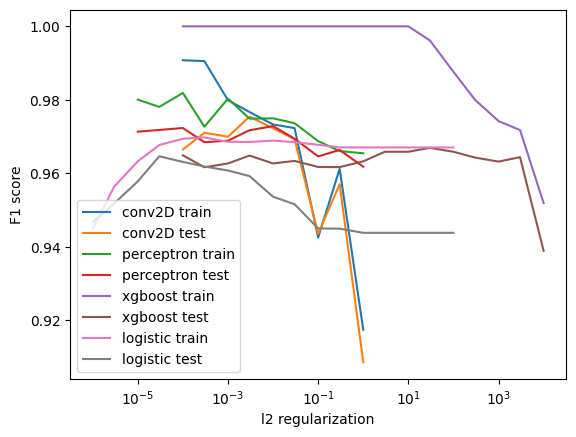

In [77]:
plt.plot(conv2d_stats[0],conv2d_stats[1],label='conv2D train')
plt.plot(conv2d_stats[0],conv2d_stats[2],label='conv2D test')
plt.plot(per_stats[0],per_stats[1],label='perceptron train')
plt.plot(per_stats[0],per_stats[2],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,train_pred),5)}")
print(f"xgboost test {np.round(f1_score(target_test,test_pred),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")
print("best regularized")
print(f"perceptron train {np.round(np.max(per_stats[1]),5)}")
print(f"perceptron test {np.round(np.max(per_stats[2]),5)}")
print(f"conv2d train {np.round(np.max(conv2d_stats[1]),5)}")
print(f"conv2d test {np.round(np.max(conv2d_stats[2]),5)}")
print(f"xgboost train {np.round(np.max(stats_xgb[1]),5)}")
print(f"xgboost test {np.round(np.max(stats_xgb[2]),5)}")
print(f"logistic train {np.round(np.max(stats_log[1]),5)}")
print(f"logistic test {np.round(np.max(stats_log[2]),5)}")

Convolutional neural network looks best in f1 score, then maybe perceptron but because this is a froad peak it could be chance. Logistic regression is better than xgbboost in f1 score. 

not regularized
Logistic train 0.1629
Logistic test 0.31918
xgboost train 0.00243
xgboost test 0.16782
perceptron train 0.10522
perceptron test 0.16862
conv2d train 0.08935
conv2d test 0.16058
best regularized
perceptron train 0.09107
perceptron test 0.16509
conv2d train 0.07705
conv2d test 0.12805
xgboost train 0.00231
xgboost test 0.12609
logistic train 0.16288
logistic test 0.27219


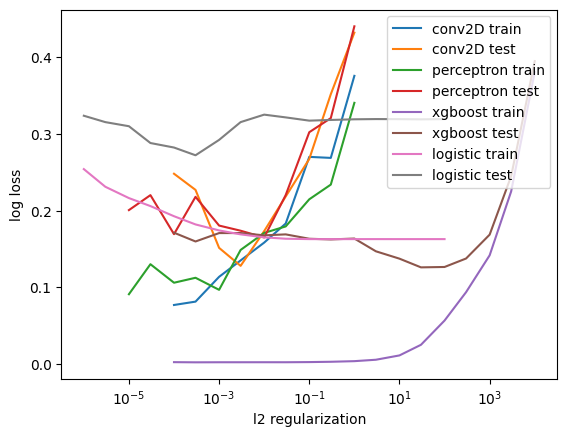

In [78]:
plt.plot(conv2d_stats[0],conv2d_stats[3],label='conv2D train')
plt.plot(conv2d_stats[0],conv2d_stats[4],label='conv2D test')
plt.plot(per_stats[0],per_stats[3],label='perceptron train')
plt.plot(per_stats[0],per_stats[4],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(log_loss(target_train,l_train_pred_prob),5)}")
print(f"Logistic test {np.round(log_loss(target_test,l_test_pred_prob),5)}")
print(f"xgboost train {np.round(log_loss(target_train,train_pred_prob),5)}")
print(f"xgboost test {np.round(log_loss(target_test,test_pred_prob),5)}")
print(f"perceptron train {np.round(log_loss(target_train,(m_train)),5)}")
print(f"perceptron test {np.round(log_loss(target_test,(m_test)),5)}")
print(f"conv2d train {np.round(log_loss(target_train,(c_train)),5)}")
print(f"conv2d test {np.round(log_loss(target_test,(c_test)),5)}")
print("best regularized")
print(f"perceptron train {np.round(np.min(per_stats[3]),5)}")
print(f"perceptron test {np.round(np.min(per_stats[4]),5)}")
print(f"conv2d train {np.round(np.min(conv2d_stats[3]),5)}")
print(f"conv2d test {np.round(np.min(conv2d_stats[4]),5)}")
print(f"xgboost train {np.round(np.min(stats_xgb[3]),5)}")
print(f"xgboost test {np.round(np.min(stats_xgb[4]),5)}")
print(f"logistic train {np.round(np.min(stats_log[3]),5)}")
print(f"logistic test {np.round(np.min(stats_log[4]),5)}")

Similar but not identical. Convolutional network is also better than perceptron, after regularization it is also better than xgboost unregularized, but the best regularization of xgboost is better. Logistic is here the worst. The best regularization depends slightkly on metric, it is 0.003 for log loss while it is 0.01 for f1 score for convolutional network in a previous run, it depends somewhat on the run. 

Next step is to run the best of all four options, possible average and look on the miss classsifed cases to see what is the reason. I decide to use log loss as to find the best one. 


First printing the value, also for checking that it is not an isolated minimum. 

In [94]:
best_reg_conv=conv2d_stats[0,(np.argmin(conv2d_stats[4]))]
print(f"best regularization of conv 2d is {best_reg_conv}")
best_reg_per=per_stats[0,(np.argmin(per_stats[4]))]
print(f"best regularization of perceptron is {best_reg_per}")
best_reg_xgb=stats_xgb[0,(np.argmin(stats_xgb[4]))]
print(f"best regularization of xgboost is {best_reg_xgb}")
best_reg_log=stats_log[0,(np.argmin(stats_log[4]))]
print(f"best regularization of logistic is {best_reg_log}")

best regularization of conv 2d is 0.003
best regularization of perceptron is 0.01
best regularization of xgboost is 30.0
best regularization of logistic is 0.0003


In [38]:
xc2=XGBClassifier(max_depth=6,reg_lambda=30.0).fit(feature_train,target_train)
x2_train_pred_prob=xc2.predict_proba(feature_train)
x2_test_pred_prob=xc2.predict_proba(feature_test)

In [39]:
lc2=LogisticRegression(penalty='l2',C=0.0003,max_iter=3000).fit(feature_train,target_train)
l2_train_pred_prob=lc2.predict_proba(feature_train)
l2_test_pred_prob=lc2.predict_proba(feature_test)

In [46]:
num_features=121
keep_prob=1
modelp =BinaryClassification3(num_features)            
modelp.to(device)
loss_stats_test3 = {
        'train': [], 'test': []
        }
torch_fit(modelp,train_loader,test_loader,200,64,0.001,loss_stats_test3,l2reg=0.01)
p2_test_pred=pred_torch(modelp,test_loader)
p2_train_pred=pred_torch(modelp,train_loader_pred)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.04088 | Test Loss: 0.49599
Epoch 002: | Train Loss: 0.50597 | Test Loss: 0.53979
Epoch 003: | Train Loss: 0.43764 | Test Loss: 0.53153
Epoch 004: | Train Loss: 0.39680 | Test Loss: 0.53381
Epoch 005: | Train Loss: 0.39999 | Test Loss: 0.28938
Epoch 006: | Train Loss: 0.30387 | Test Loss: 0.34185
Epoch 007: | Train Loss: 0.30235 | Test Loss: 0.27242
Epoch 008: | Train Loss: 0.31966 | Test Loss: 0.26578
Epoch 009: | Train Loss: 0.32095 | Test Loss: 0.38952
Epoch 010: | Train Loss: 0.29844 | Test Loss: 0.48360
Epoch 011: | Train Loss: 0.43530 | Test Loss: 0.46372
Epoch 012: | Train Loss: 0.27722 | Test Loss: 0.51225
Epoch 013: | Train Loss: 0.29768 | Test Loss: 0.32998
Epoch 014: | Train Loss: 0.33874 | Test Loss: 0.40119
Epoch 015: | Train Loss: 0.32683 | Test Loss: 0.50694
Epoch 016: | Train Loss: 0.34178 | Test Loss: 0.15942
Epoch 017: | Train Loss: 0.31957 | Test Loss: 0.32572
Epoch 018: | Train Loss: 0.29313 | Test Loss: 0.38489
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.26034 | Test Loss: 0.26075
Epoch 154: | Train Loss: 0.23500 | Test Loss: 0.18938
Epoch 155: | Train Loss: 0.23374 | Test Loss: 0.18839
Epoch 156: | Train Loss: 0.23000 | Test Loss: 0.25649
Epoch 157: | Train Loss: 0.25587 | Test Loss: 0.32149
Epoch 158: | Train Loss: 0.28299 | Test Loss: 0.20237
Epoch 159: | Train Loss: 0.28800 | Test Loss: 0.20109
Epoch 160: | Train Loss: 0.25873 | Test Loss: 0.18836
Epoch 161: | Train Loss: 0.26270 | Test Loss: 0.18741
Epoch 162: | Train Loss: 0.28537 | Test Loss: 0.37769
Epoch 163: | Train Loss: 0.27512 | Test Loss: 0.21287
Epoch 164: | Train Loss: 0.26495 | Test Loss: 0.32374
Epoch 165: | Train Loss: 0.25447 | Test Loss: 0.18818
Epoch 166: | Train Loss: 0.23098 | Test Loss: 0.19937
Epoch 167: | Train Loss: 0.23193 | Test Loss: 0.19706
Epoch 168: | Train Loss: 0.23105 | Test Loss: 0.38261
Epoch 169: | Train Loss: 0.25857 | Test Loss: 0.37692
Epoch 170: | Train Loss: 0.25464 | Test Loss: 0.37894
Epoch 171: | Train Loss: 0.2

In [47]:
#slower than perceptron but not much 
keep_prob=1
modelc =CNNBinary3()            
modelc.to(device)
loss_stats_test_c = {
        'train': [], 'test': []
        }
torch_fit(modelc,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test_c,l2reg=0.003)
c2_test_pred=pred_torch(modelc,test_im_loader)
c2_train_pred=pred_torch(modelc,train_im_loader_pred)

Begin training.


/tmp/ipykernel_2776/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 12.76737 | Test Loss: 0.70719
Epoch 002: | Train Loss: 0.75091 | Test Loss: 0.67656
Epoch 003: | Train Loss: 0.54253 | Test Loss: 1.10639
Epoch 004: | Train Loss: 0.56587 | Test Loss: 0.47097
Epoch 005: | Train Loss: 0.41924 | Test Loss: 0.45655
Epoch 006: | Train Loss: 0.43257 | Test Loss: 0.45340
Epoch 007: | Train Loss: 0.42267 | Test Loss: 0.53626
Epoch 008: | Train Loss: 0.58955 | Test Loss: 0.45419
Epoch 009: | Train Loss: 0.38110 | Test Loss: 0.44252
Epoch 010: | Train Loss: 0.40125 | Test Loss: 0.44150
Epoch 011: | Train Loss: 0.32849 | Test Loss: 0.38627
Epoch 012: | Train Loss: 0.38591 | Test Loss: 0.34586
Epoch 013: | Train Loss: 0.34754 | Test Loss: 0.45165
Epoch 014: | Train Loss: 0.30847 | Test Loss: 0.26132
Epoch 015: | Train Loss: 0.28132 | Test Loss: 0.29117
Epoch 016: | Train Loss: 0.26041 | Test Loss: 0.32077
Epoch 017: | Train Loss: 0.46137 | Test Loss: 3.53859
Epoch 018: | Train Loss: 0.30392 | Test Loss: 0.21698
Epoch 019: | Train Loss: 0.

Epoch 153: | Train Loss: 0.17986 | Test Loss: 0.29703
Epoch 154: | Train Loss: 0.21474 | Test Loss: 0.25235
Epoch 155: | Train Loss: 0.19066 | Test Loss: 0.23527
Epoch 156: | Train Loss: 0.17122 | Test Loss: 0.29989
Epoch 157: | Train Loss: 0.17572 | Test Loss: 0.25319
Epoch 158: | Train Loss: 0.20951 | Test Loss: 0.24401
Epoch 159: | Train Loss: 0.17200 | Test Loss: 0.23879
Epoch 160: | Train Loss: 0.20428 | Test Loss: 0.20052
Epoch 161: | Train Loss: 0.18968 | Test Loss: 0.23618
Epoch 162: | Train Loss: 0.19446 | Test Loss: 0.23701
Epoch 163: | Train Loss: 0.19014 | Test Loss: 0.24076
Epoch 164: | Train Loss: 0.18725 | Test Loss: 0.25144
Epoch 165: | Train Loss: 0.16741 | Test Loss: 0.23592
Epoch 166: | Train Loss: 0.18569 | Test Loss: 0.30070
Epoch 167: | Train Loss: 0.18459 | Test Loss: 0.30510
Epoch 168: | Train Loss: 0.22406 | Test Loss: 0.24113
Epoch 169: | Train Loss: 0.17294 | Test Loss: 0.24038
Epoch 170: | Train Loss: 0.18402 | Test Loss: 0.39712
Epoch 171: | Train Loss: 0.1

Looking on wrong classifications concentrating on the ones which are clealy wrong. 

In [76]:
#per 50 
#conv 55
#xgb 64
c=0
for i in range(len(x2_test_pred_prob)):
    avg=(x2_test_pred_prob[i,1]+c2_test_pred[i]+p2_test_pred[i])/3
    p=np.array([x2_test_pred_prob[i,1],p2_test_pred[i],c2_test_pred[i]])
    if abs(avg-target_test[i])>0.9:
        print(f"case {i} galaxy is {target_test[i]} with p {np.round(p,3)}")
        c+=1
print(c)        

case 5 galaxy is True with p [0.01  0.001 0.004]
case 159 galaxy is True with p [0.006 0.045 0.013]
case 162 galaxy is False with p [0.909 0.949 0.969]
case 224 galaxy is False with p [0.99  0.89  0.946]
case 350 galaxy is True with p [0.005 0.007 0.011]
case 457 galaxy is False with p [0.891 0.919 0.975]
case 479 galaxy is True with p [0.002 0.    0.   ]
case 741 galaxy is False with p [0.994 0.938 0.96 ]
case 1075 galaxy is False with p [0.921 0.908 0.884]
case 1096 galaxy is False with p [0.939 0.988 0.995]
case 1192 galaxy is False with p [0.988 0.955 0.976]
case 1324 galaxy is False with p [0.953 0.88  0.951]
case 1515 galaxy is False with p [0.907 0.853 0.956]
case 1561 galaxy is False with p [0.984 0.997 0.998]
14


(1578, 1, 11, 11)


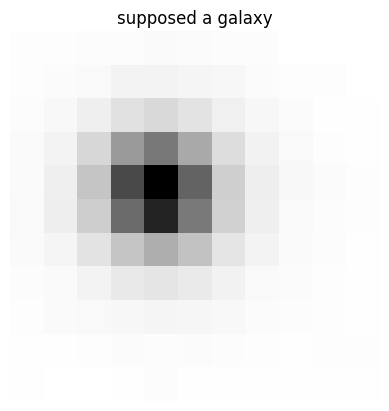

In [71]:
print(image_test.shape)
plt.axis('off')
plt.title("supposedly a galaxy")
plt.imshow(1-image_test[5,0,:,:].T,cmap=cm.gray, interpolation='nearest')

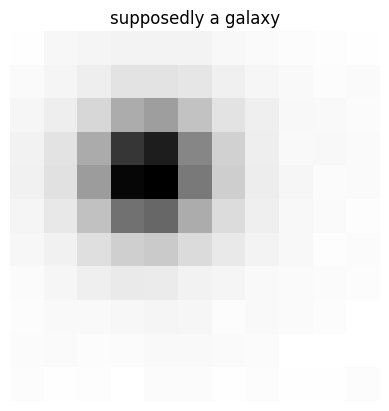

In [77]:
plt.axis('off')
plt.title("supposedly a galaxy")
plt.imshow(1-image_test[159,0,:,:].T,cmap=cm.gray, interpolation='nearest')

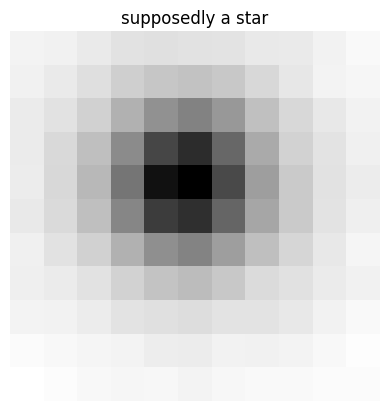

In [78]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[162,0,:,:].T,cmap=cm.gray, interpolation='nearest')

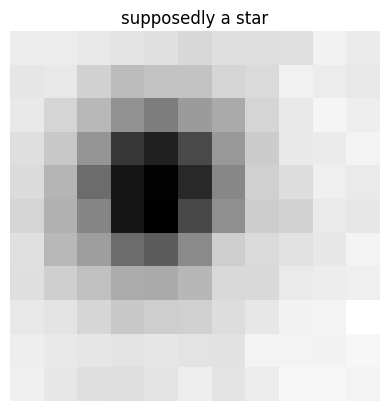

In [72]:

plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[32,0,:,:].T,cmap=cm.gray, interpolation='nearest')

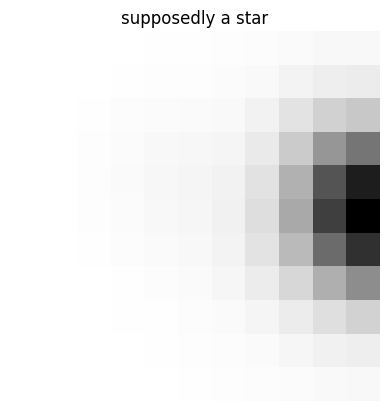

In [74]:
#is on data border makes it difficult 
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[175,0,:,:].T,cmap=cm.gray, interpolation='nearest')

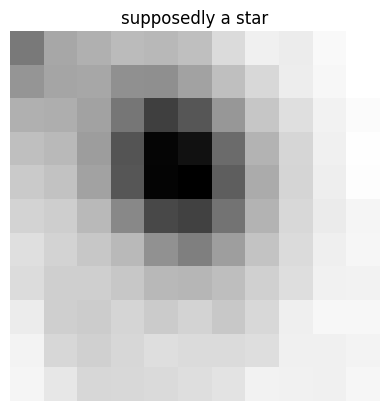

In [79]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[224,0,:,:].T,cmap=cm.gray, interpolation='nearest')

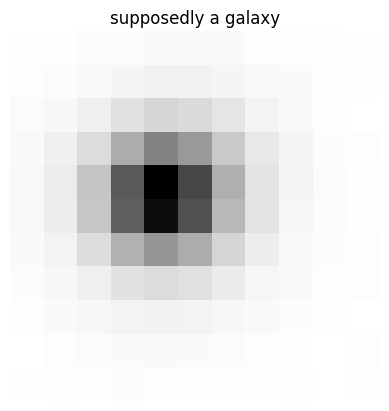

In [80]:
plt.axis('off')
plt.title("supposedly a galaxy")
plt.imshow(1-image_test[350,0,:,:].T,cmap=cm.gray, interpolation='nearest')

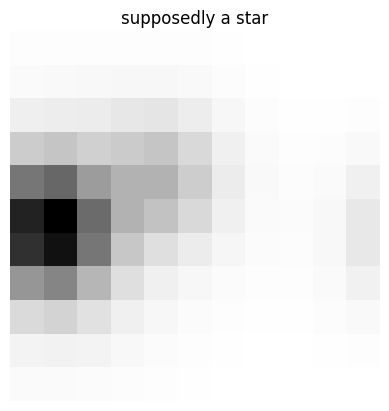

In [75]:
#several objects there, could be trhat coordinates are not exact 
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[363,0,:,:].T,cmap=cm.gray, interpolation='nearest')

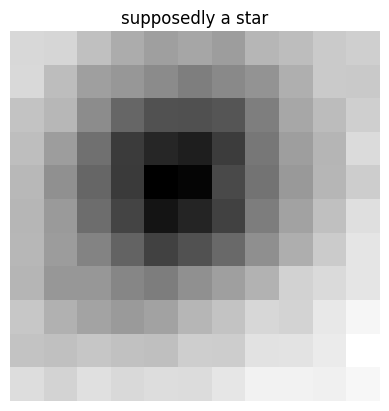

In [81]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[457,0,:,:].T,cmap=cm.gray, interpolation='nearest')

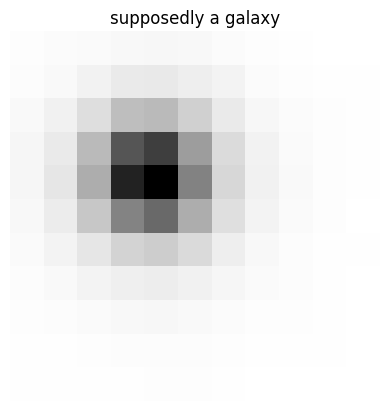

In [82]:
plt.axis('off')
plt.title("supposedly a galaxy")
plt.imshow(1-image_test[479,0,:,:].T,cmap=cm.gray, interpolation='nearest')

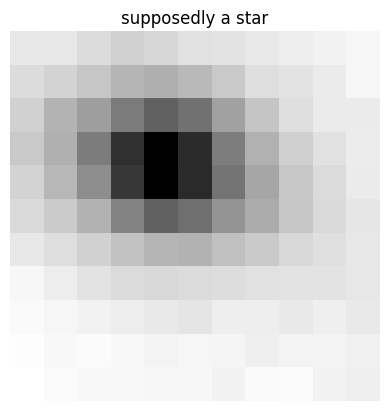

In [83]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[741,0,:,:].T,cmap=cm.gray, interpolation='nearest')

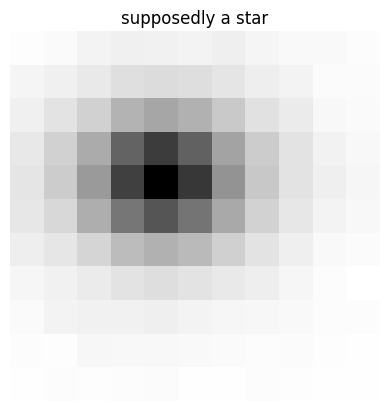

In [84]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1075,0,:,:].T,cmap=cm.gray, interpolation='nearest')

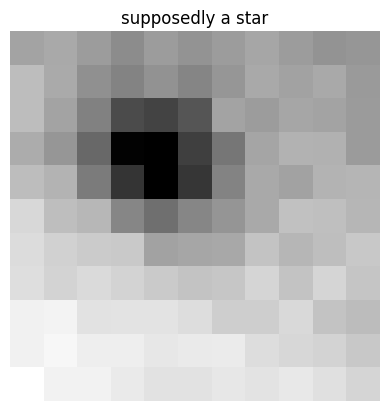

In [85]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1096,0,:,:].T,cmap=cm.gray, interpolation='nearest')

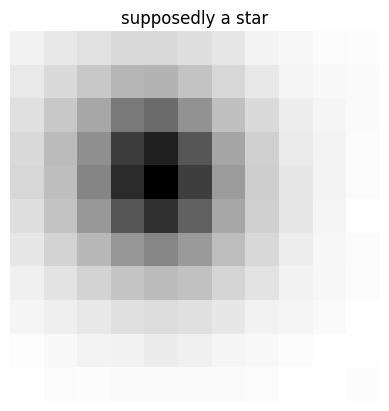

In [86]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1192,0,:,:].T,cmap=cm.gray, interpolation='nearest')

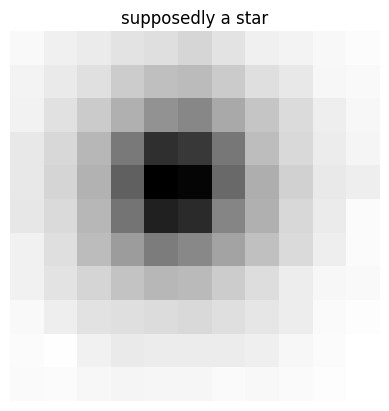

In [87]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1324,0,:,:].T,cmap=cm.gray, interpolation='nearest')

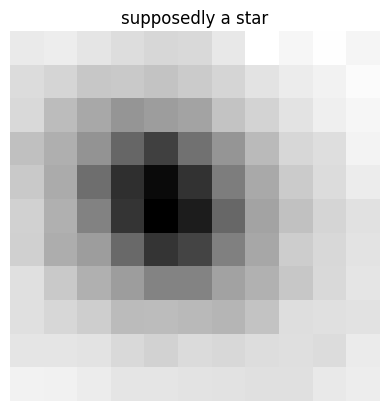

In [88]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1515,0,:,:].T,cmap=cm.gray, interpolation='nearest')

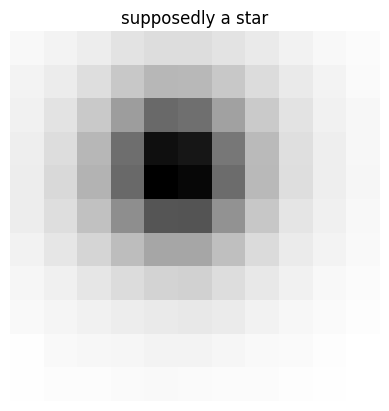

In [89]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1561,0,:,:].T,cmap=cm.gray, interpolation='nearest')

Most labelled as stars are labelled as galaxies by the algorithm, that can expected because of imblance in the sample.
All of those look rather round per eye and when there are differences it is in the level of concentration. The human eye is not particularly good in that. Thus looking on the images does not help. Algorothm are better. The labels used here come from spectra and thus are not based on the shape. In principle both test different properties and do not need to agree always. To investigate more later.  Also should get shape related parameters. 

I should also generate more data from the same images. Easy options are flipping and rotations, that add 7, thus simple size times 8. (of which half are in the other way rotating). Less clear whether adding noise works, at least needs more testing on which level is fine, it should include images which are impossible and also not too similar ones. Likely needs special splitting techniques that not too similar data is in test.  